In [7]:
import pandas as pd
import csv
import os
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from datasets import load_from_disk
from IPython.display import display
from datasets import Dataset, ClassLabel
from datetime import datetime

from llm_mri import Metrics

## Utils

In [8]:
# Constants
GRID_SIZES = [10, 20, 30, 40, 50]
SAMPLE_SIZE = 1000

# Paths
fakenews_data_path = "../data/fakenews"
processed_graphs_path = f"{fakenews_data_path}/processed/graphs"
results_path = f"{fakenews_data_path}/results"
metrics_path = f"{results_path}/metrics.csv"

model_ckpt = "distilbert/distilbert-base-multilingual-cased"

In [9]:
def get_layer_number(node_name):
    return int(node_name.split("_")[0])

def get_edge_name(source, target):
    source_layer = get_layer_number(source)
    target_layer = get_layer_number(target)
    
    if source_layer < target_layer:
        return f"{source_layer}>>{target_layer}"
    return f"{target_layer}>>{source_layer}"

    

## Process Metrics

In [10]:
def get_biggest_connected_component(graph: nx.DiGraph) -> nx.DiGraph:
    if nx.is_connected(graph.to_undirected()):
        return graph
    else:
        largest_cc = max(nx.connected_components(graph.to_undirected()), key=len)
        return graph.subgraph(largest_cc).copy()

def get_more_metrics(graph: nx.DiGraph) -> dict:
    graph_cc = get_biggest_connected_component(graph.to_undirected())
    return {
        "num_nodes": graph.number_of_nodes(),
        "num_edges": graph.number_of_edges(),
        "mean_distance": nx.average_shortest_path_length(graph_cc) if graph_cc else float('inf'),
        "diameter": nx.diameter(graph_cc) if graph_cc else float('inf'),
        "density": nx.density(graph),
        "beetweenness_centrality_mean": np.mean(list(nx.betweenness_centrality(graph).values())),
    }

def extract_metrics(graph, grid_size, sample, graph_label):
    metrics = Metrics(graph, model_name=model_ckpt, label=graph_label)

    return {**get_more_metrics(graph), **metrics.get_basic_metrics(), "grid_size": grid_size, "graph_label": graph_label, "sample": sample}

def save_metrics_to_csv(graph, grid_size, sample, csv_path, graph_label):
    metrics_dict = extract_metrics(graph, grid_size, sample, graph_label)

    # Se o arquivo estiver em branco ou não existir, adiciona o header
    add_header = not os.path.isfile(csv_path) or os.path.getsize(csv_path) == 0
    with open(csv_path, mode='a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=metrics_dict.keys())
        if add_header:
            writer.writeheader()
        writer.writerow(metrics_dict)




In [11]:
# Limpa o arquivo existente
metrics_path = f"{results_path}/metrics.csv"
# Remove o arquivo se existir, depois cria um novo vazio
if os.path.exists(metrics_path):
    os.remove(metrics_path)
with open(metrics_path, "w") as f:
    pass

for sample in range(SAMPLE_SIZE):
    for grid_size in GRID_SIZES:
        for label_type  in ["true", "fake"]:

            current_graph = nx.read_gexf(f"{processed_graphs_path}/{grid_size}/g_{label_type}_{sample}.gexf")
            save_metrics_to_csv(current_graph, grid_size, sample, metrics_path, label_type)

## Análise de Métricas com Estatísticas

In [12]:
def plot_metric_evolution_with_stats(df, metric_columns, grid_sizes):
    """
    Gera gráficos de barras comparando true e fake para cada tamanho de grid,
    com estatísticas de múltiplas execuções (média, min, max, desvio padrão).
    """
    
    for metric in metric_columns:
        # Criar a figura com len(grid_sizes) subplots (um para cada tamanho de grid)
        fig, axes = plt.subplots(
            1, 
            len(grid_sizes), 
            figsize=(4 * len(grid_sizes), 8.5), 
            sharey=False
        )
        
        # Ajustar para o caso de ter apenas um subplot
        if len(grid_sizes) == 1:
            axes = [axes]

        fig.suptitle(f'Evolução da Métrica: {metric}', fontsize=16, y=0.98)
        
        # Iterar sobre cada tamanho de grid
        for i, grid_size in enumerate(grid_sizes):
            ax = axes[i]
            
            # Filtrar os dados para o tamanho de grid atual
            df_slice = df[df['grid_size'] == grid_size]
            
            # Agrupar por tipo (true/fake) e calcular estatísticas
            stats = df_slice.groupby('graph_label')[metric].agg([
                'mean', 'std', 'min', 'max', 'count'
            ]).reset_index()
            
            # Preparar dados para plotagem
            types = ['true', 'fake']
            x_pos = np.arange(len(types))
            width = 0.35
            
            # Cores
            colors = {'true': '#3498db', 'fake': '#e74c3c'}
            
            # Plotar barras com erro padrão (std)
            bars = []
            for j, graph_type in enumerate(types):
                if graph_type in stats['graph_label'].values:
                    row = stats[stats['graph_label'] == graph_type].iloc[0]
                    mean_val = row['mean']
                    std_val = row['std']
                    
                    bar = ax.bar(
                        j,
                        mean_val,
                        yerr=std_val,
                        capsize=5,
                        color=colors[graph_type],
                        alpha=0.7,
                        width=width,
                        label=f"{graph_type.capitalize()} (n={int(row['count'])})",
                        error_kw={'linewidth': 2}
                    )
                    bars.append(bar)
                    
                    # Adicionar valores no topo da barra
                    ax.text(
                        j, 
                        mean_val + std_val, 
                        f'{mean_val:.2f}',
                        ha='center', 
                        va='bottom',
                        fontweight='bold'
                    )
                    
                    # Adicionar min/max abaixo
                    ax.text(
                        j,
                        mean_val - std_val - (mean_val * 0.05),
                        f'[{row["min"]:.2f}-{row["max"]:.2f}]',
                        ha='center',
                        va='top',
                        fontsize=8,
                        style='italic'
                    )
            
            ax.set_title(f'Grid Size: {grid_size}', fontsize=12, fontweight='bold')
            ax.set_xticks(x_pos)
            ax.set_xticklabels(['True', 'Fake'])
            ax.set_xlabel('Tipo de Grafo', fontweight='bold')
            
            # Label Y apenas no primeiro subplot
            if i == 0:
                ax.set_ylabel(metric, fontweight='bold')
            
            ax.grid(axis='y', linestyle='--', alpha=0.3)
            # Remove a legenda individual de cada subplot
            ax.legend().remove() if ax.get_legend() else None

        # Adiciona legenda única na parte de baixo
        handles, labels = axes[0].get_legend_handles_labels()
        if not handles:
            # Se não houver legenda no primeiro subplot, cria manualmente
            from matplotlib.patches import Patch
            handles = [Patch(facecolor='#3498db', alpha=0.7), Patch(facecolor='#e74c3c', alpha=0.7)]
            labels = ['True', 'Fake']
        
        fig.legend(handles, labels, loc='lower center', ncol=2, fontsize=11, 
                   bbox_to_anchor=(0.5, -0.05), frameon=True, fancybox=True, shadow=True)
        
        plt.tight_layout(rect=[0, 0.08, 1, 0.96])
        plt.show()
        
    print(f"\nForam gerados {len(metric_columns)} gráficos (um para cada métrica).")
    print("Cada barra mostra: valor médio ± desvio padrão")
    print("Entre colchetes: [mínimo-máximo]")

Total de métricas encontradas: 16
Métricas: ['num_nodes', 'num_edges', 'mean_distance', 'diameter', 'density', 'beetweenness_centrality_mean', 'mean_degree', 'var_degree', 'skew_degree', 'kurt_degree', 'mean_strength', 'var_strength', 'skew_strength', 'kurt_strength', 'assortativity', 'center_of_mass']



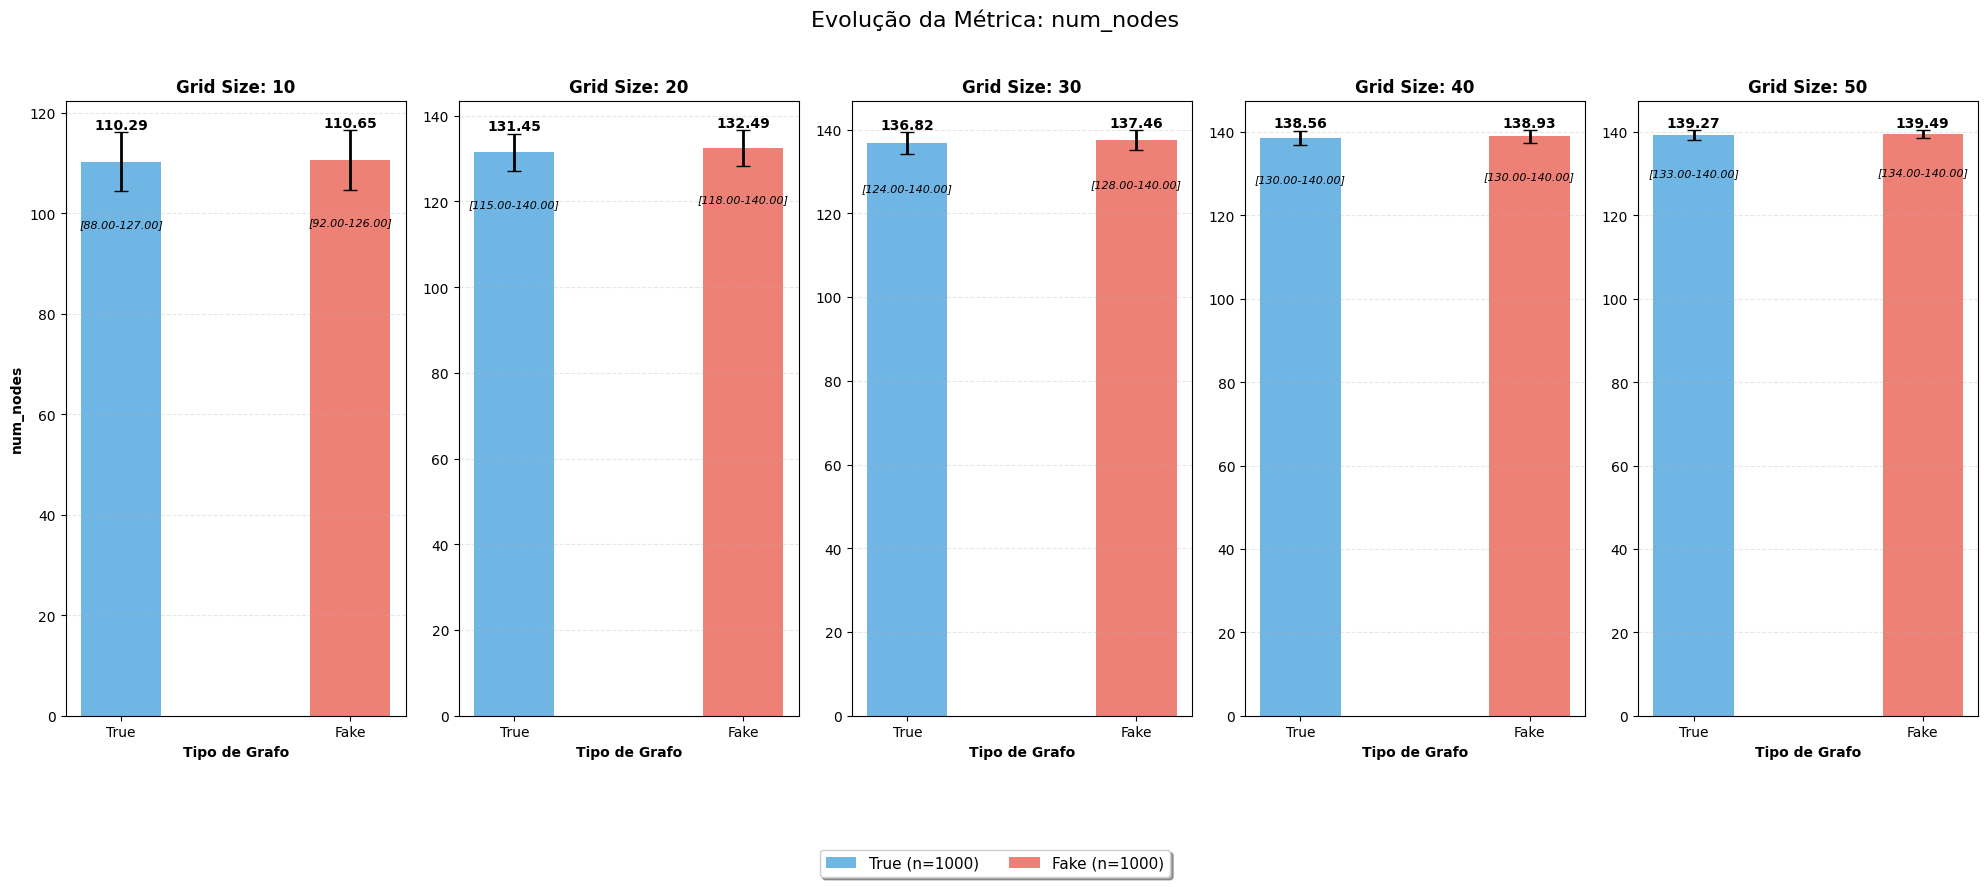

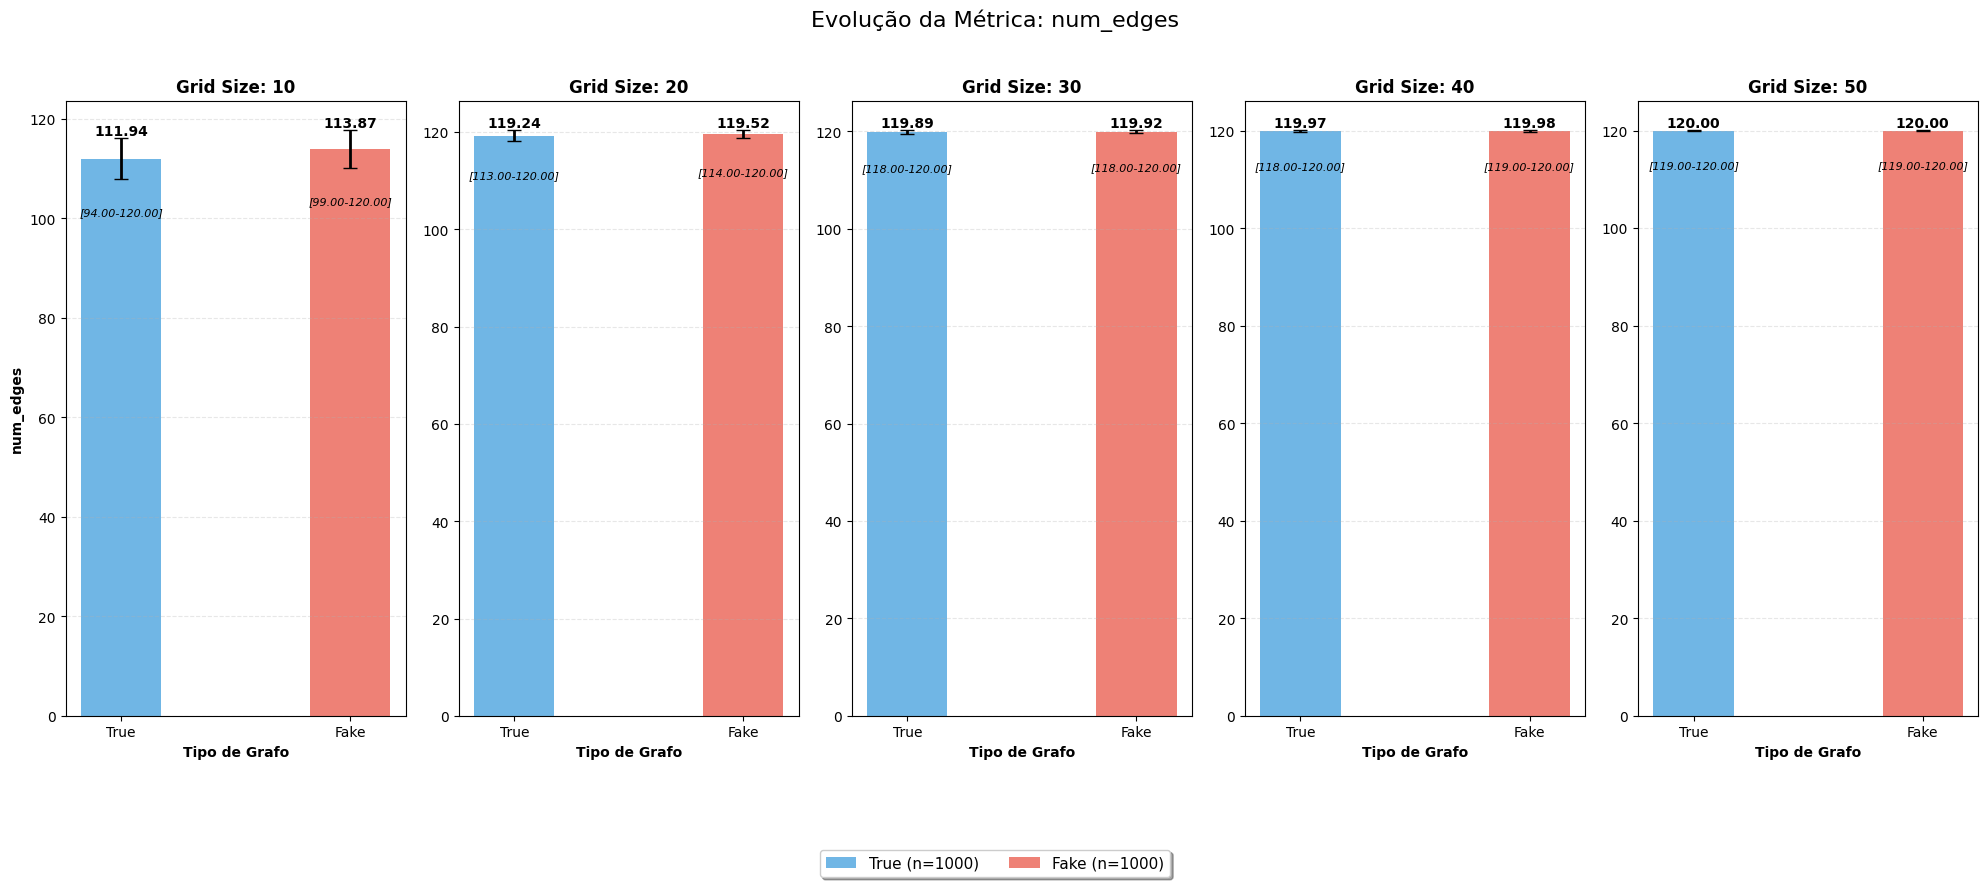

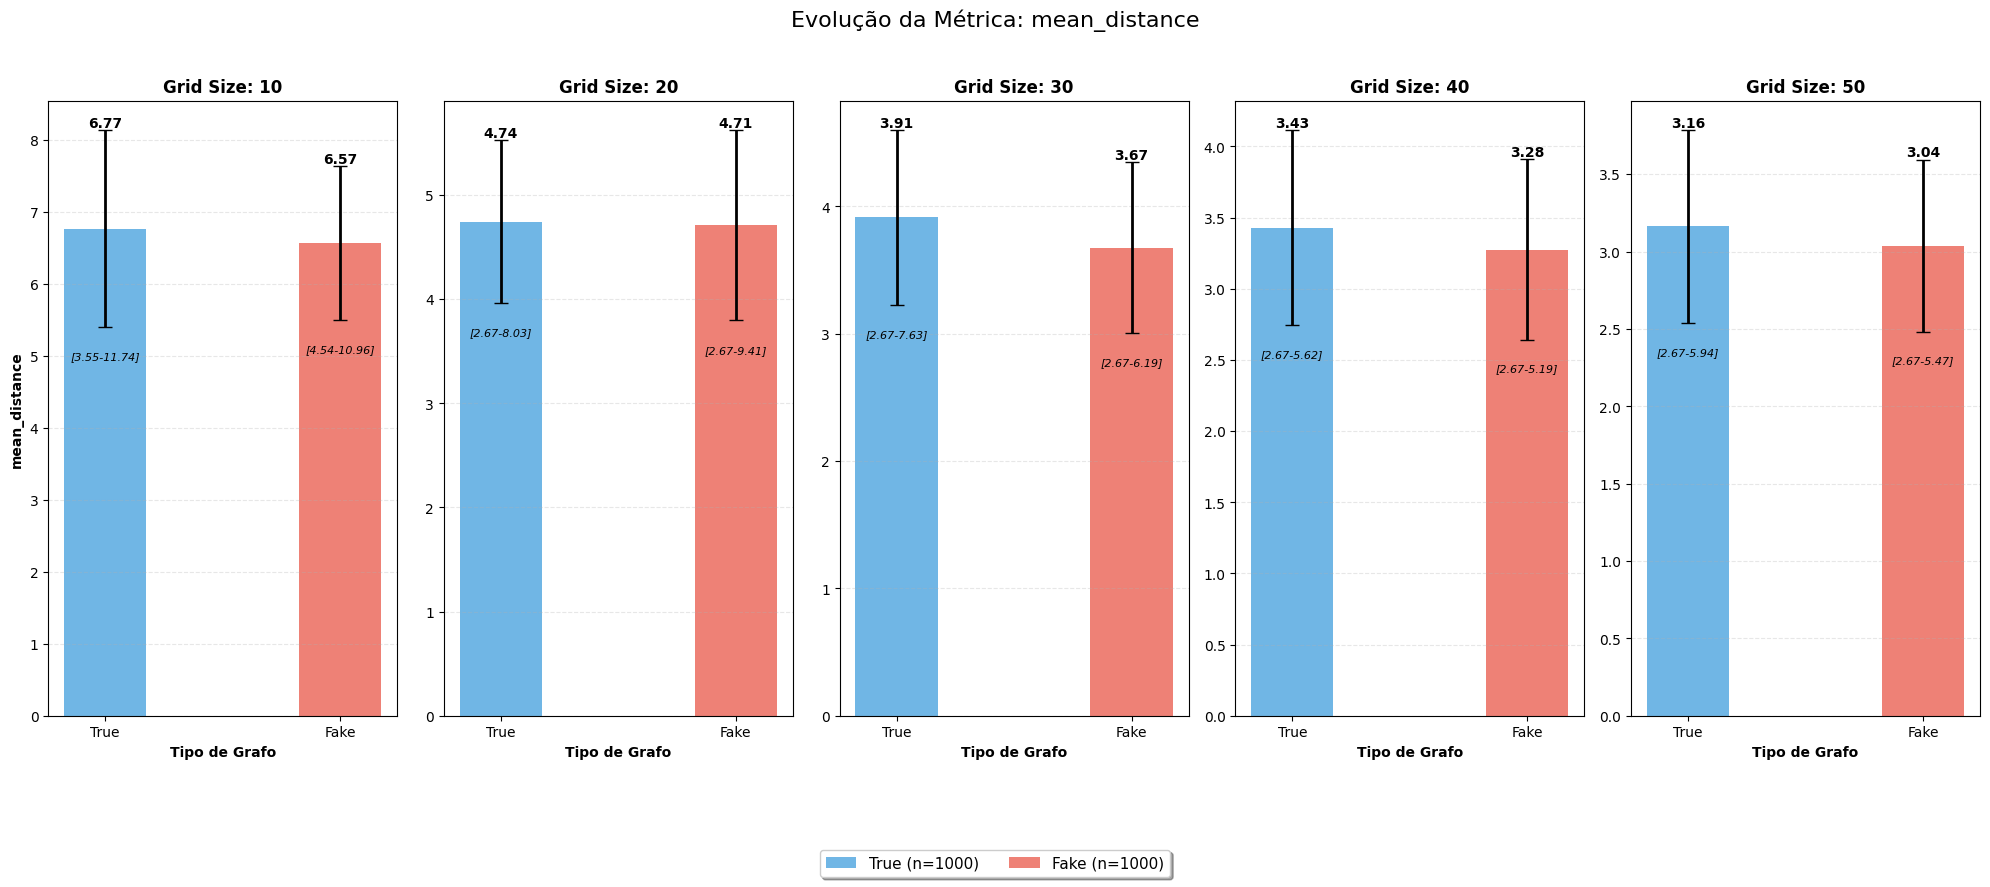

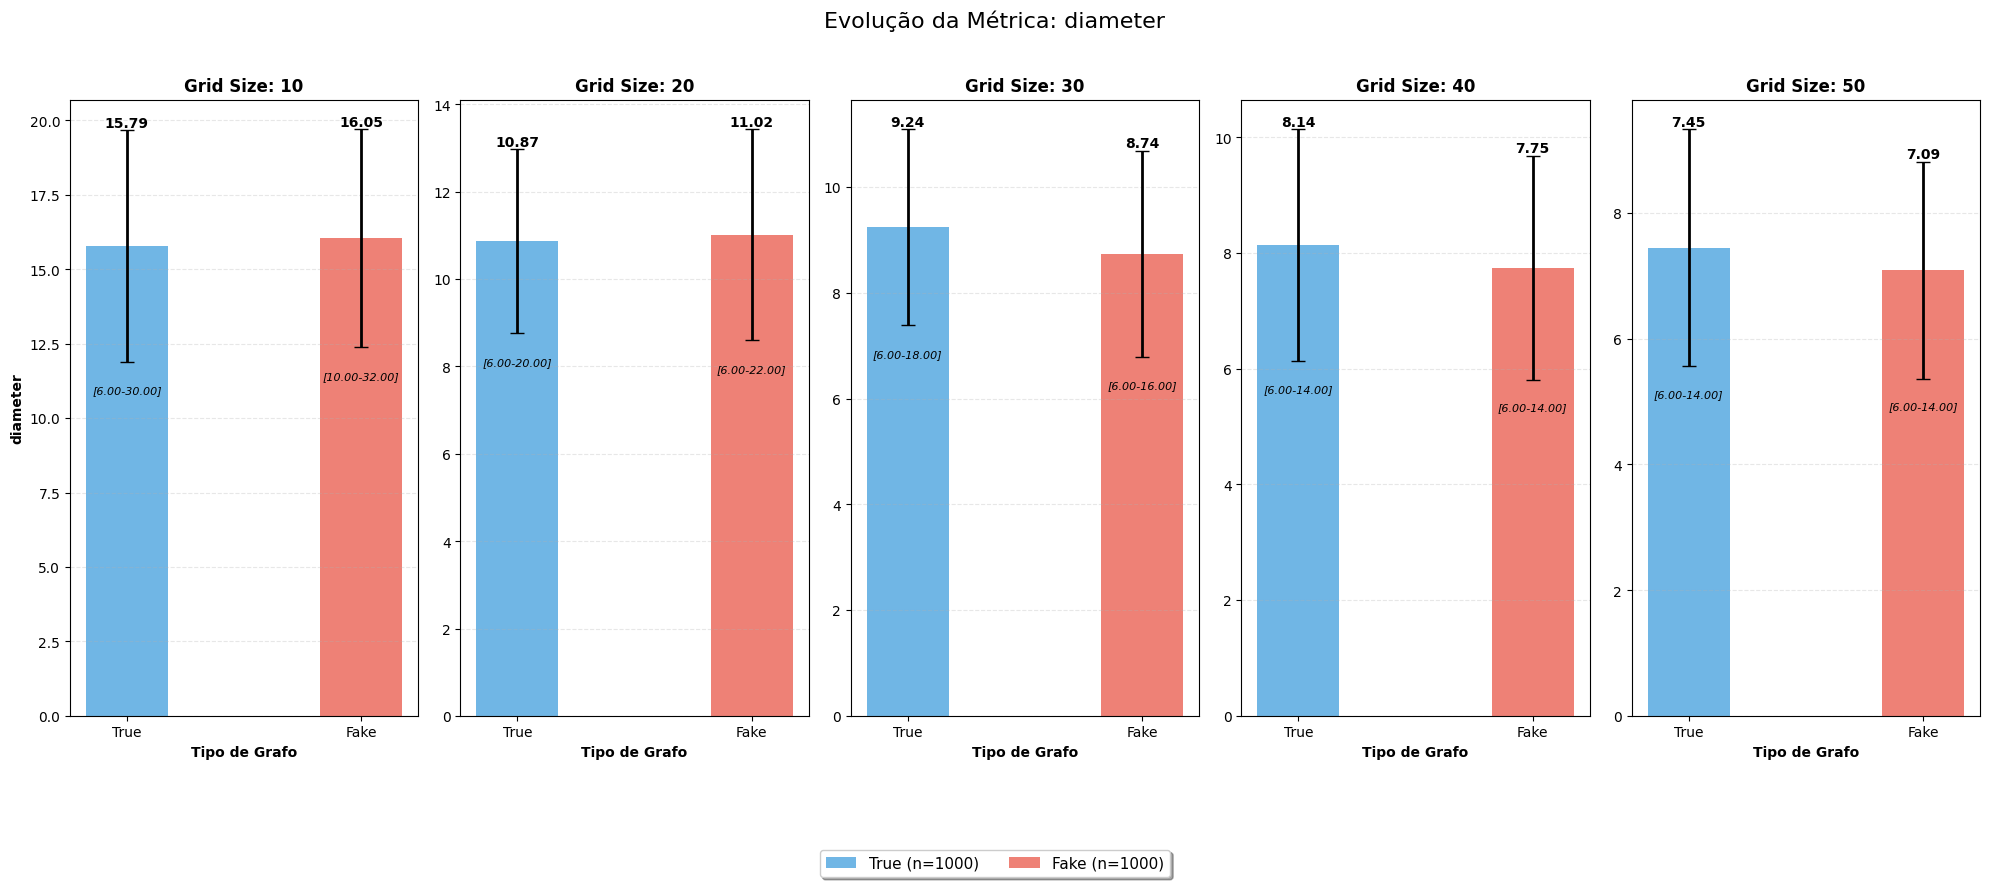

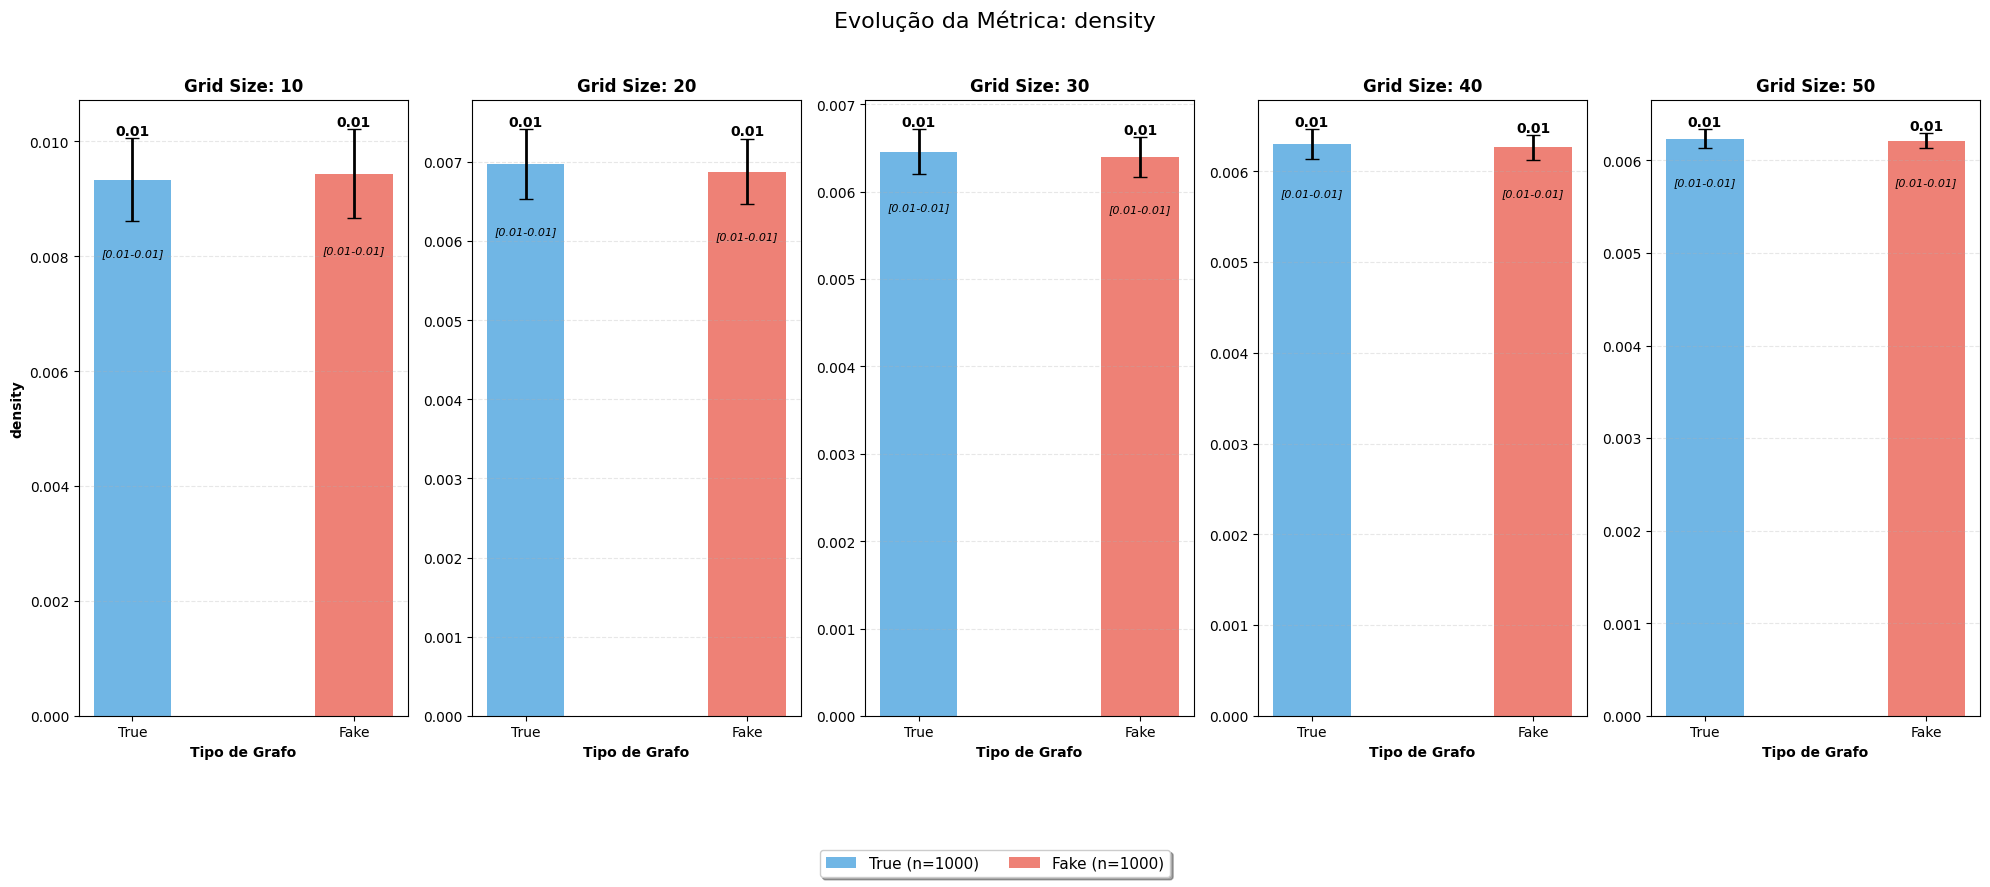

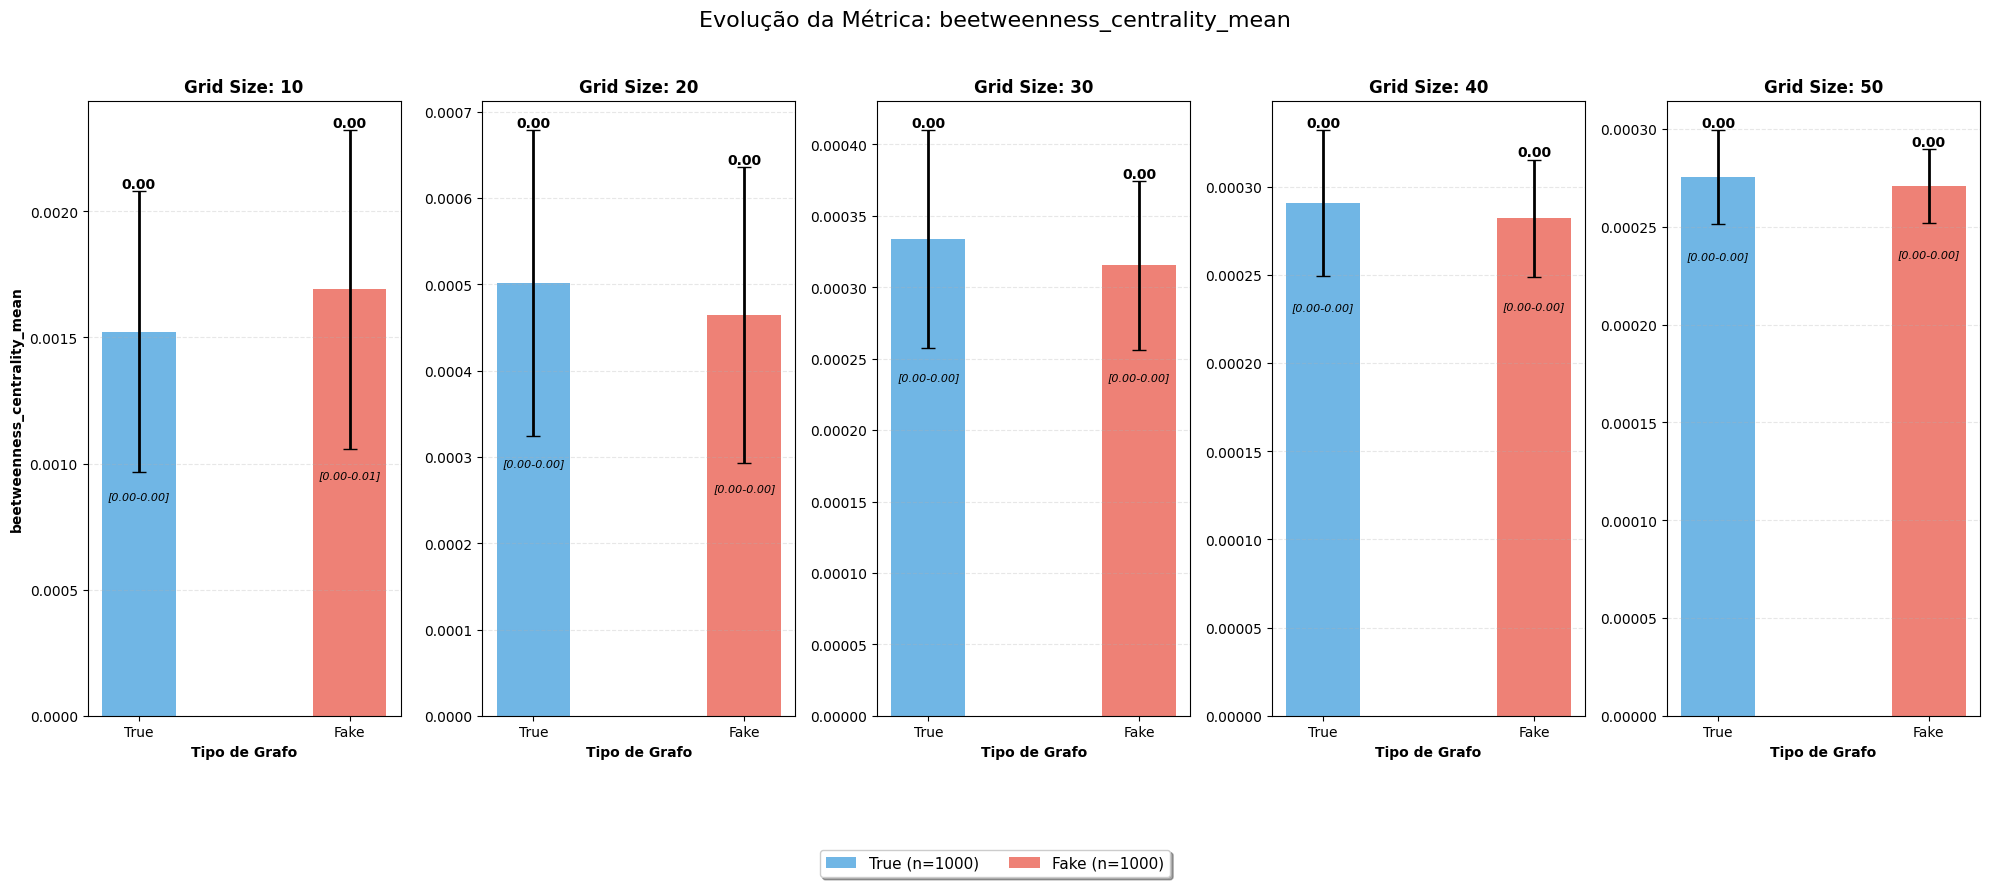

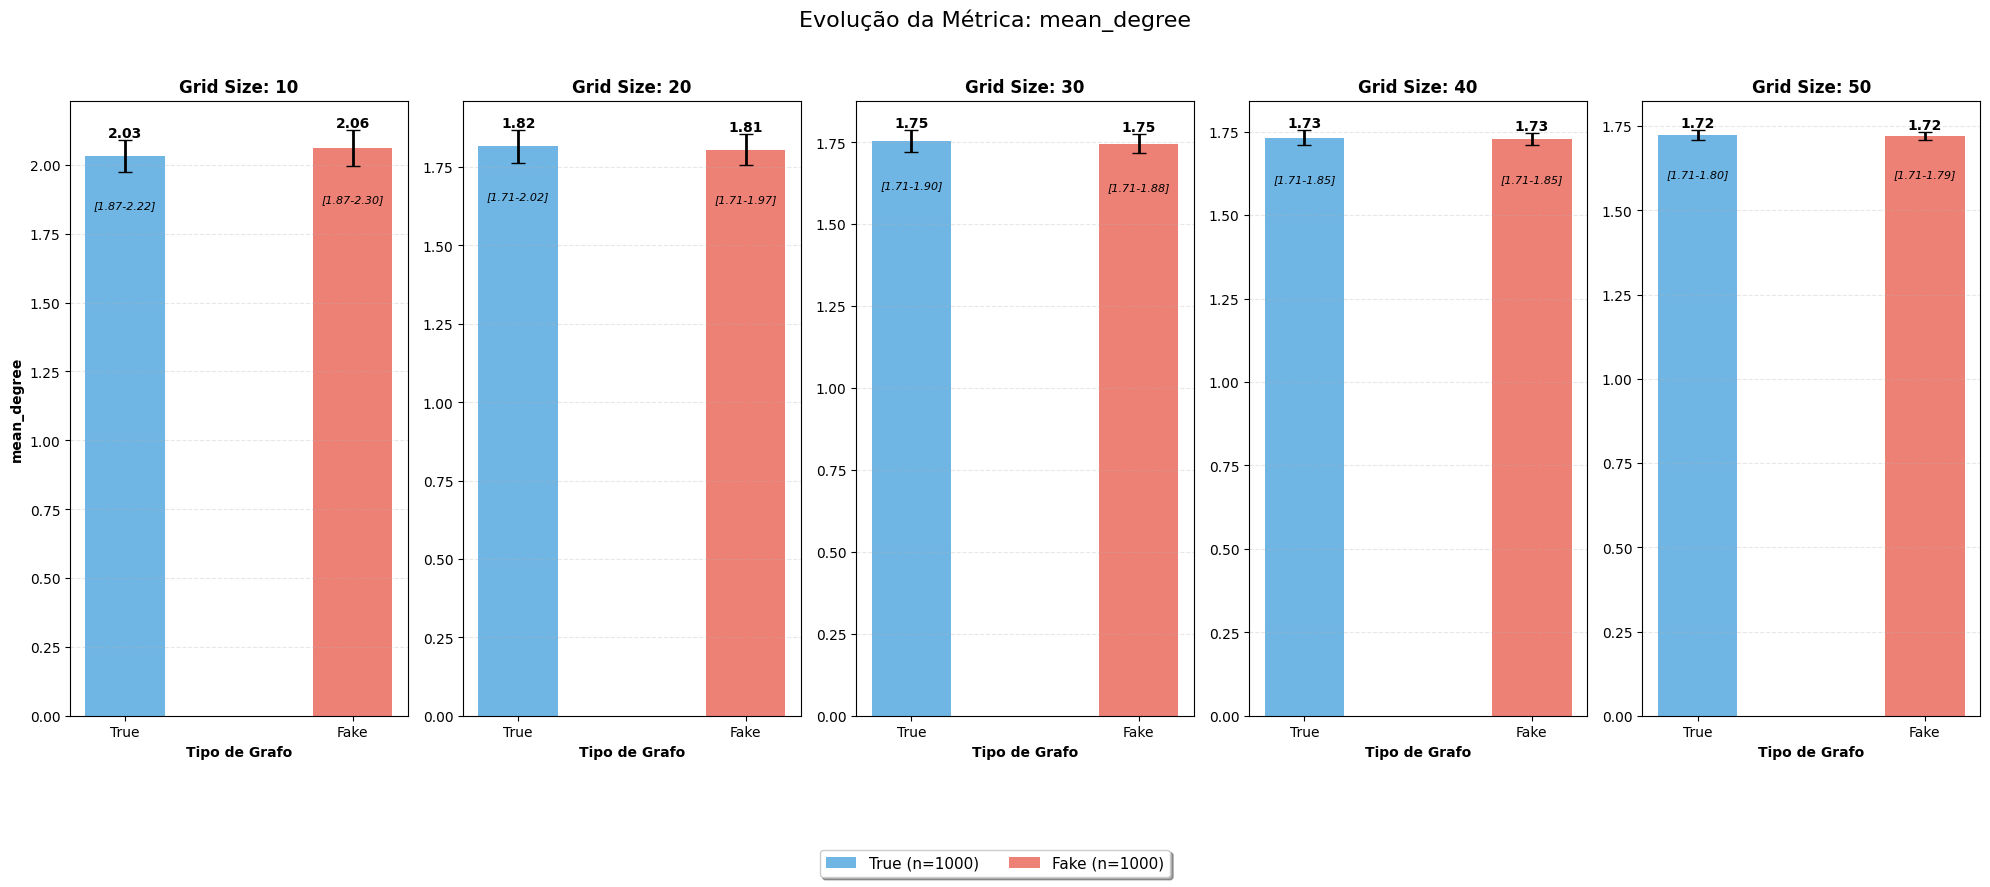

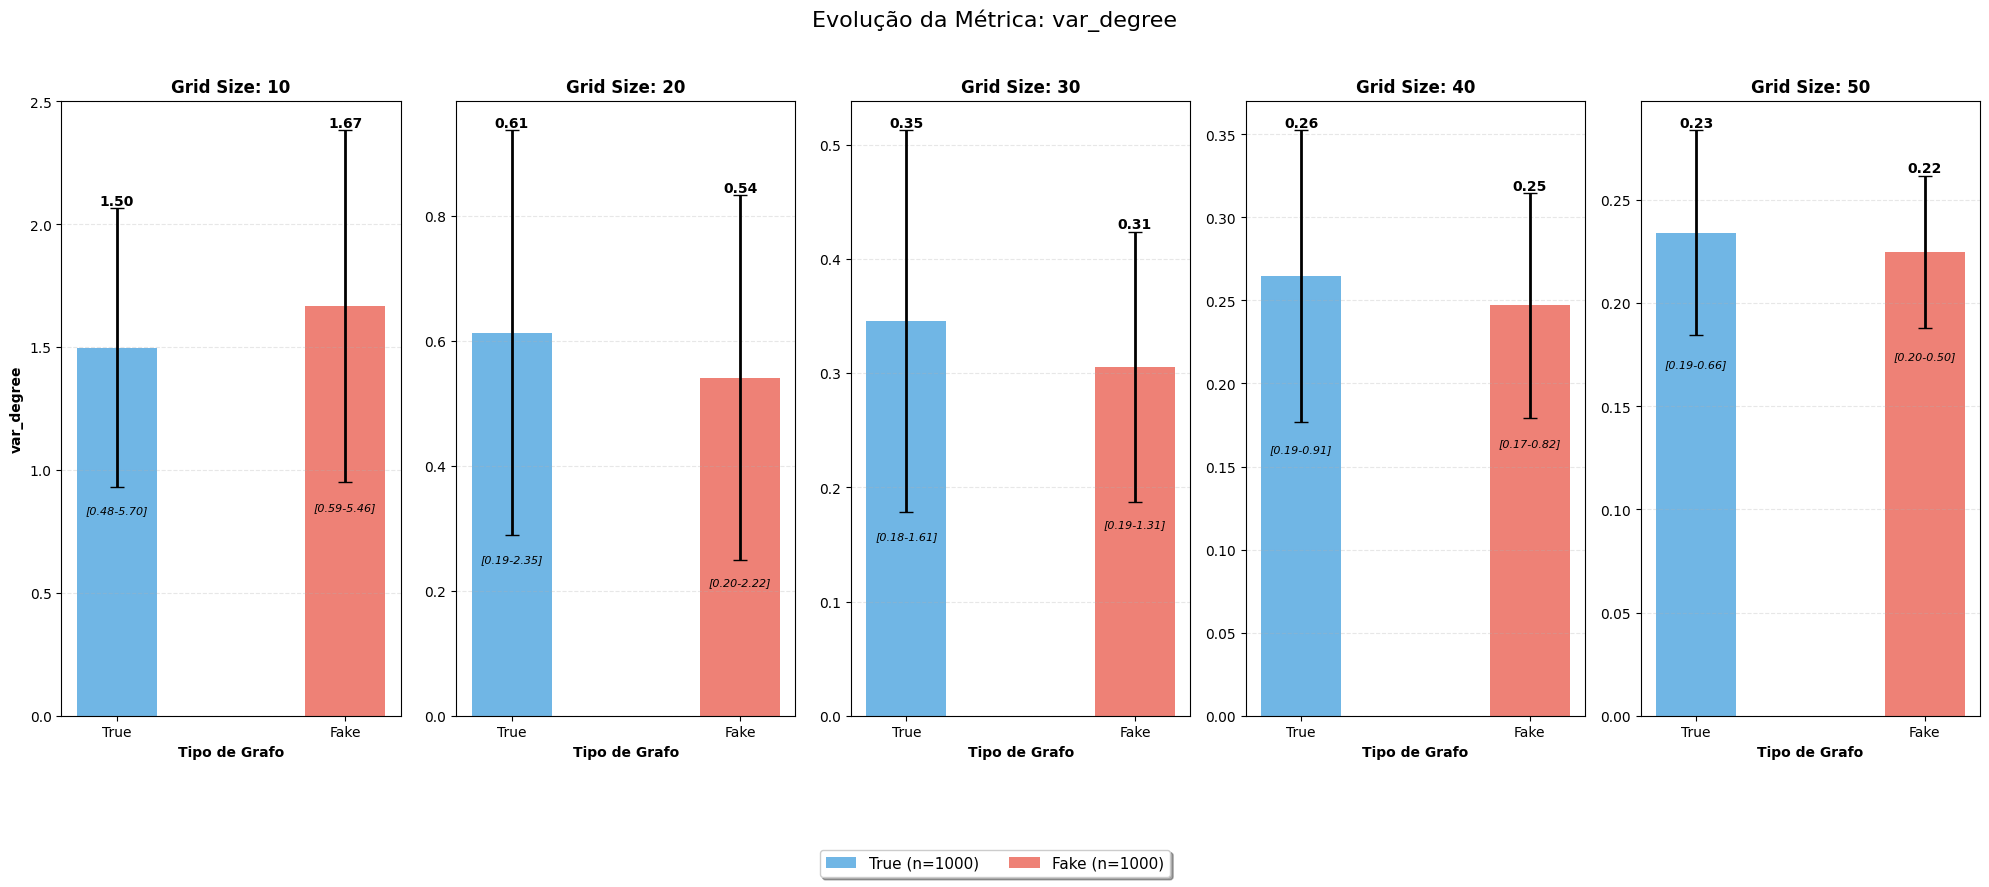

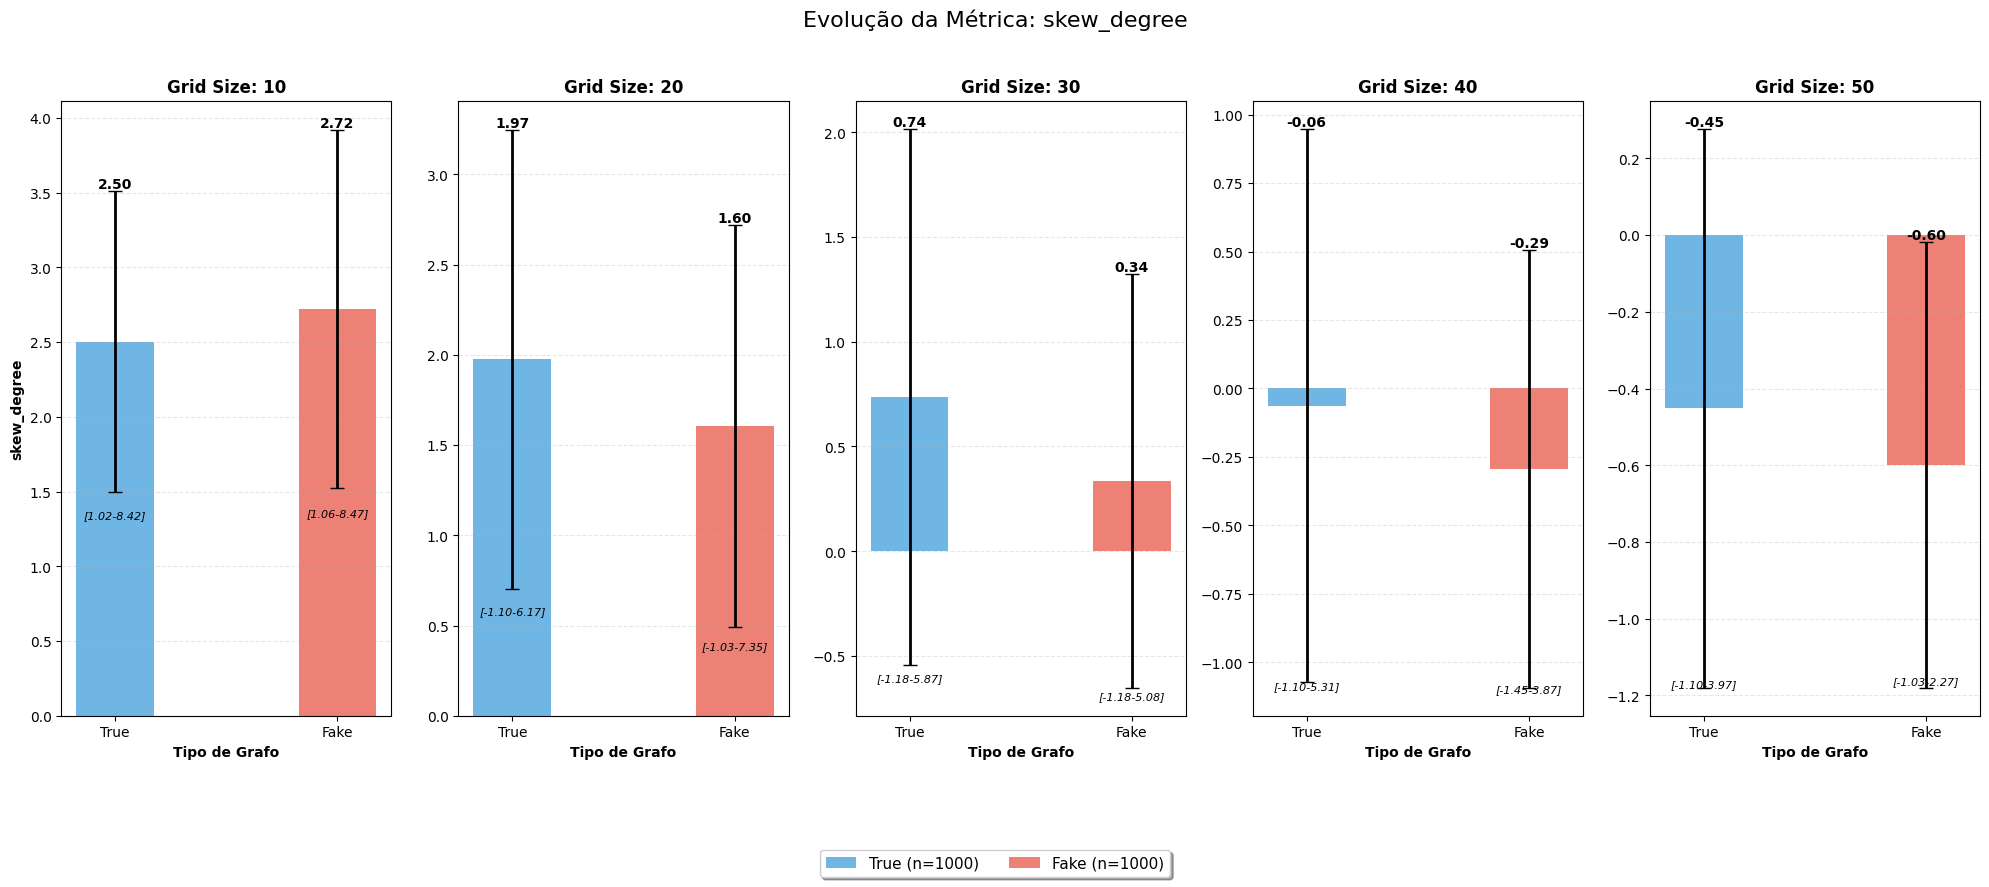

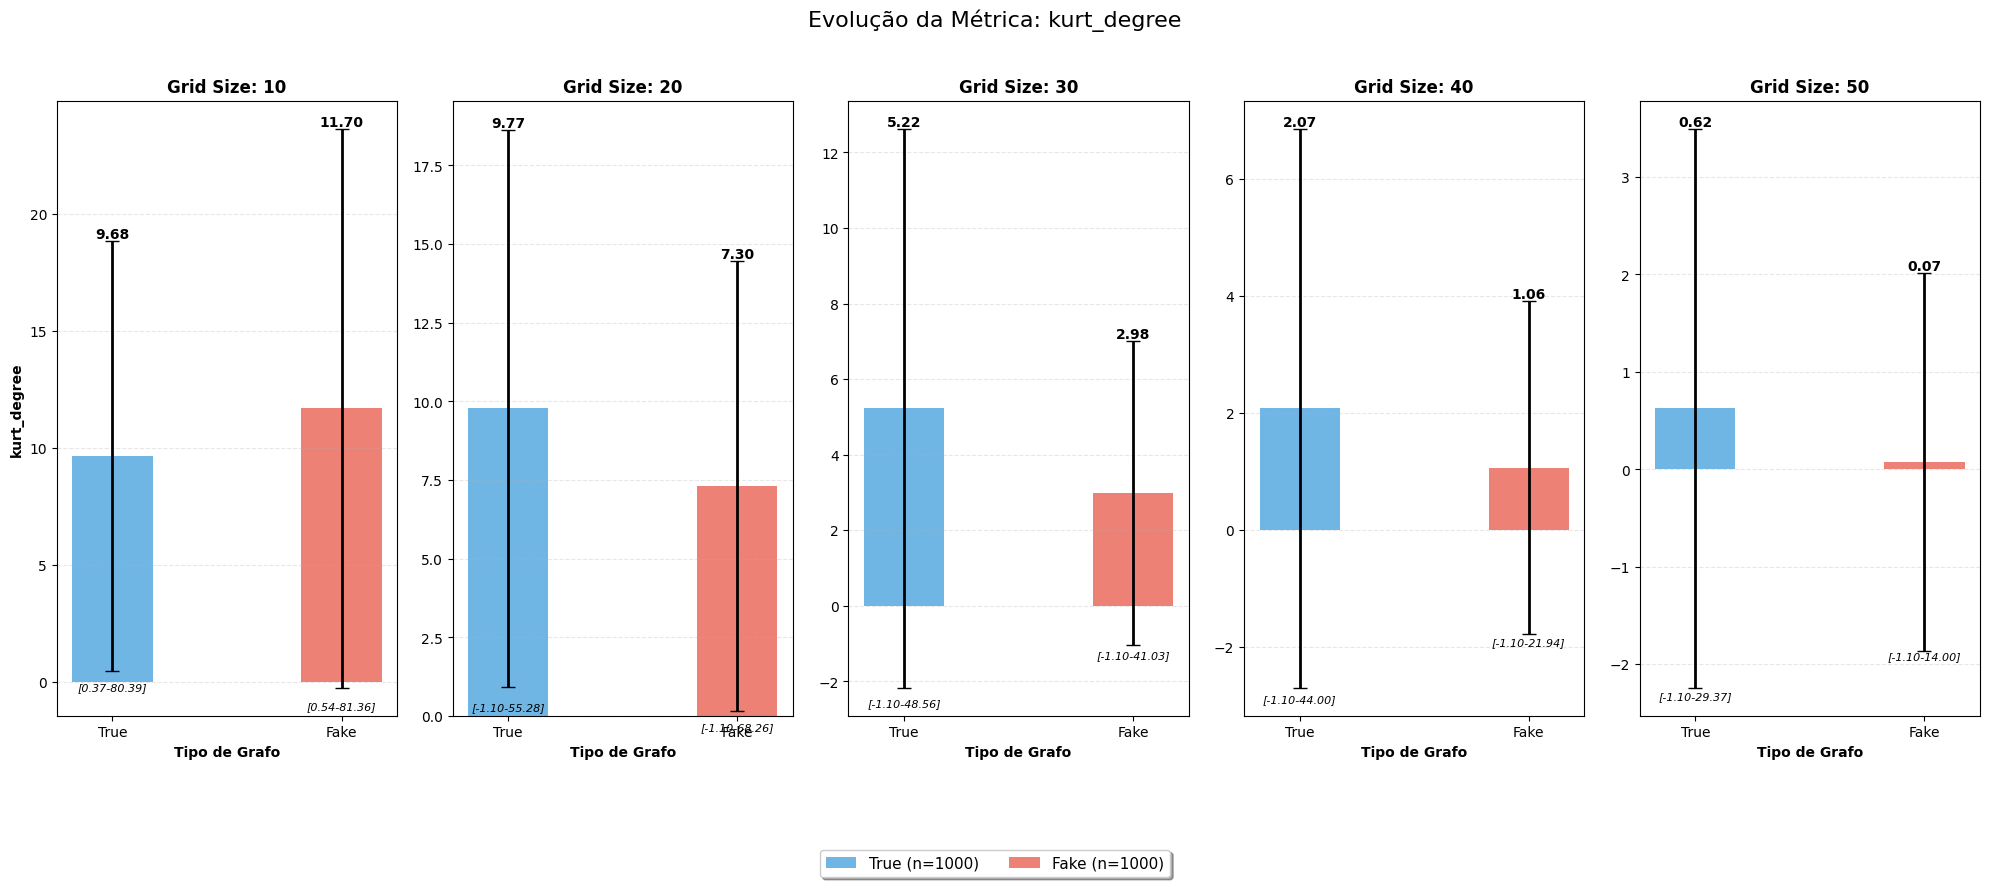

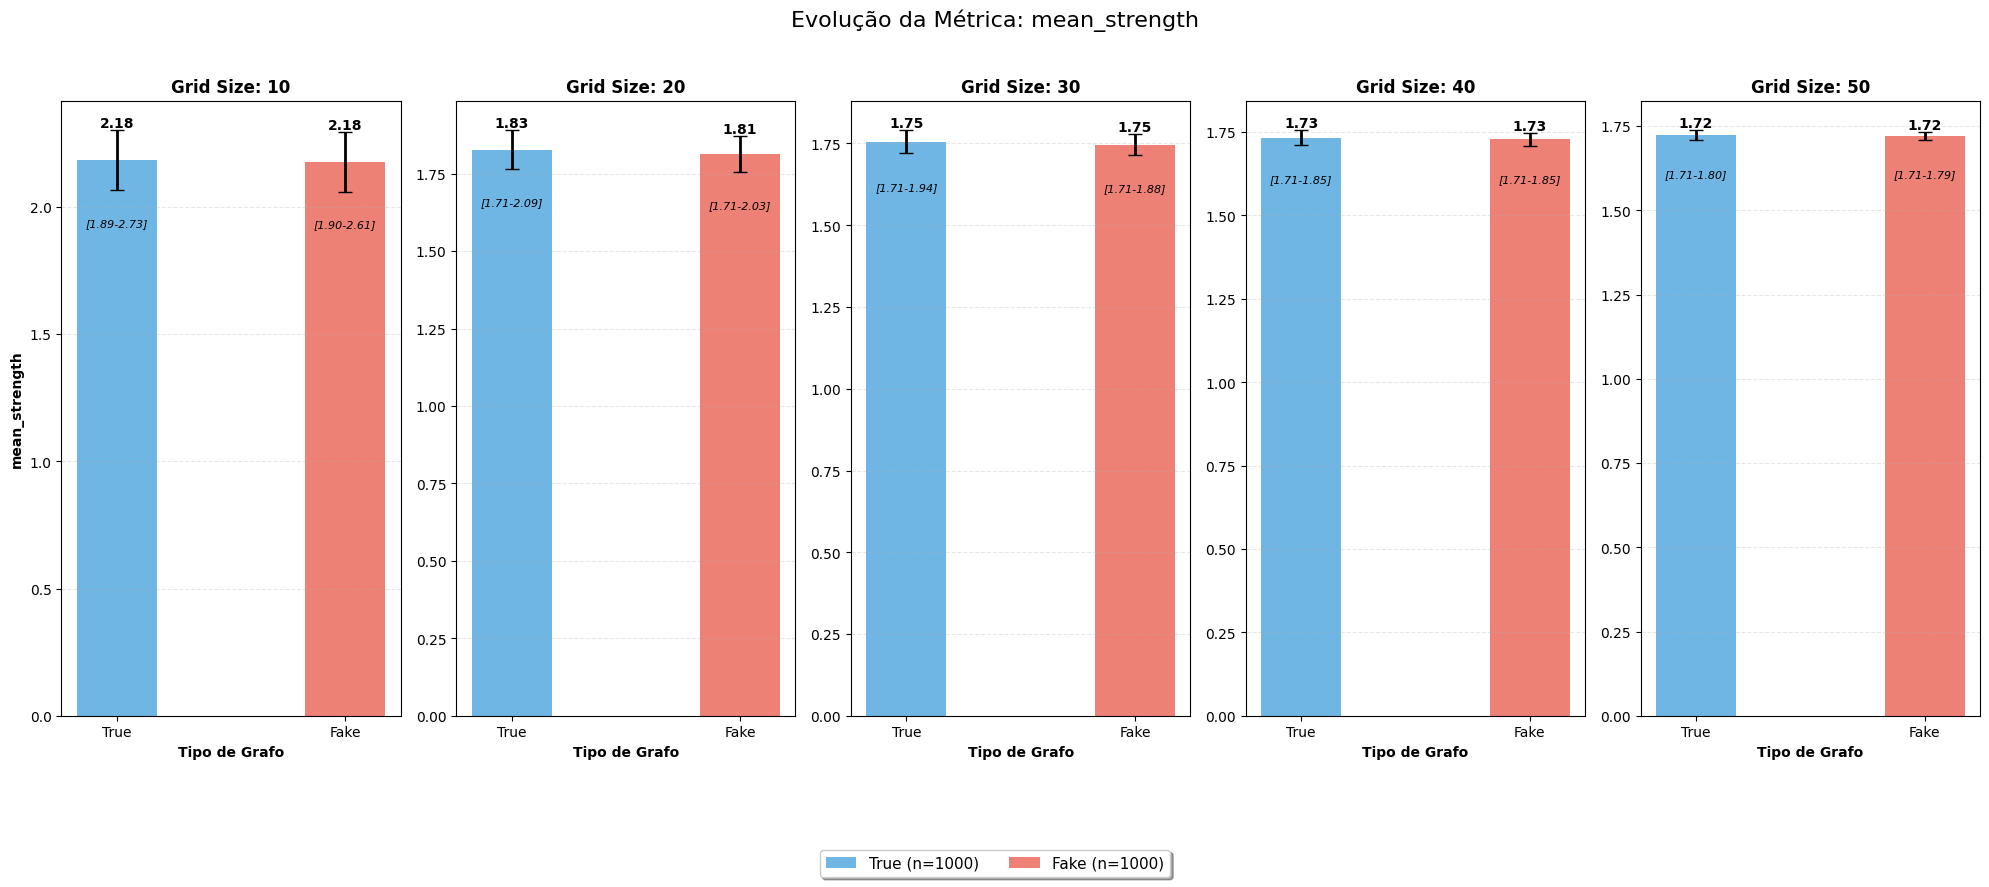

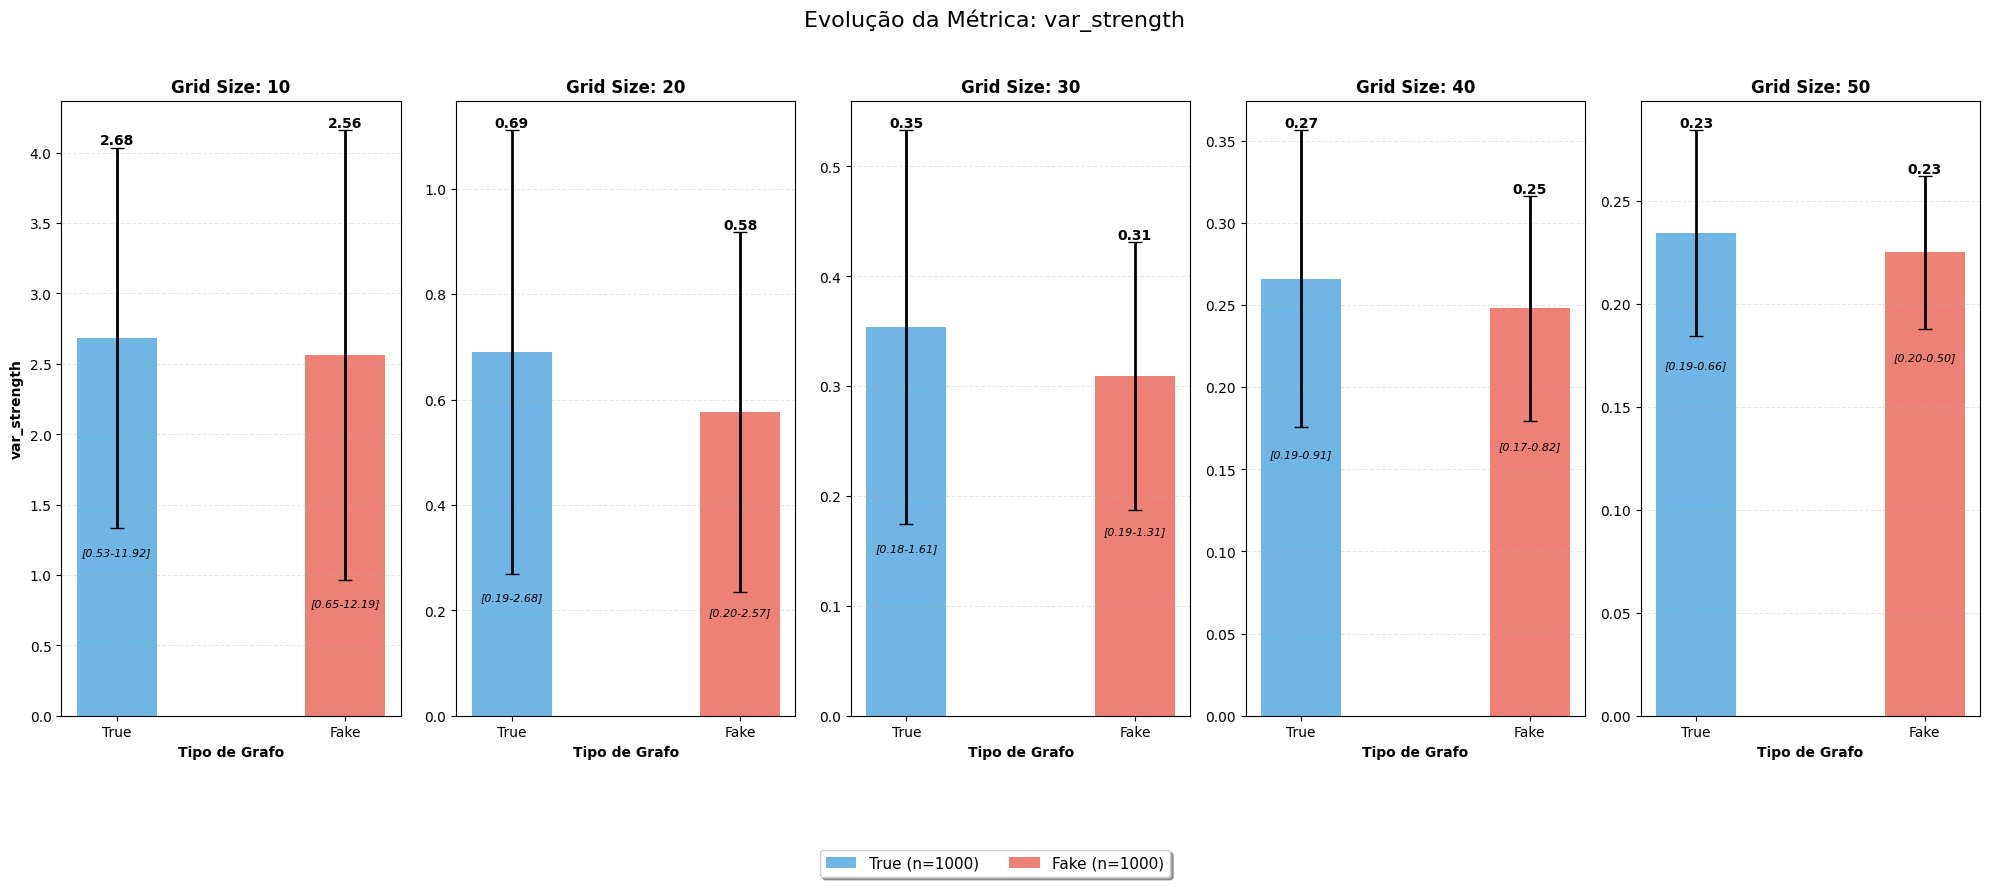

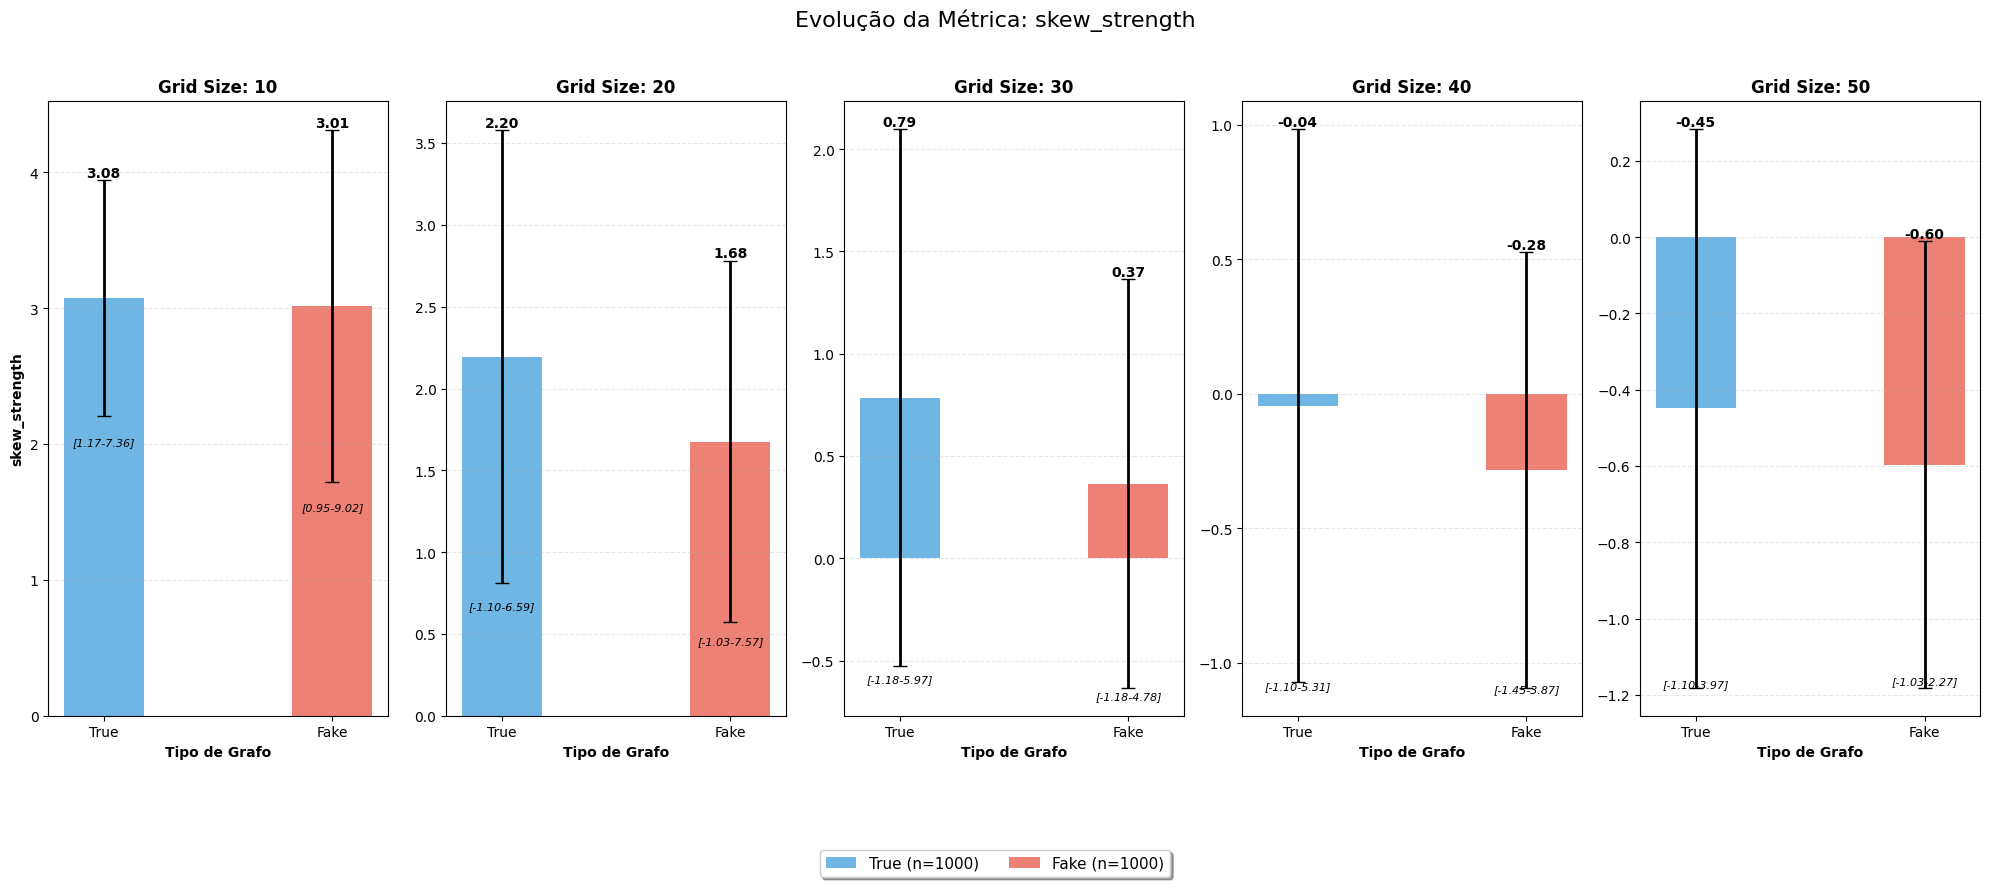

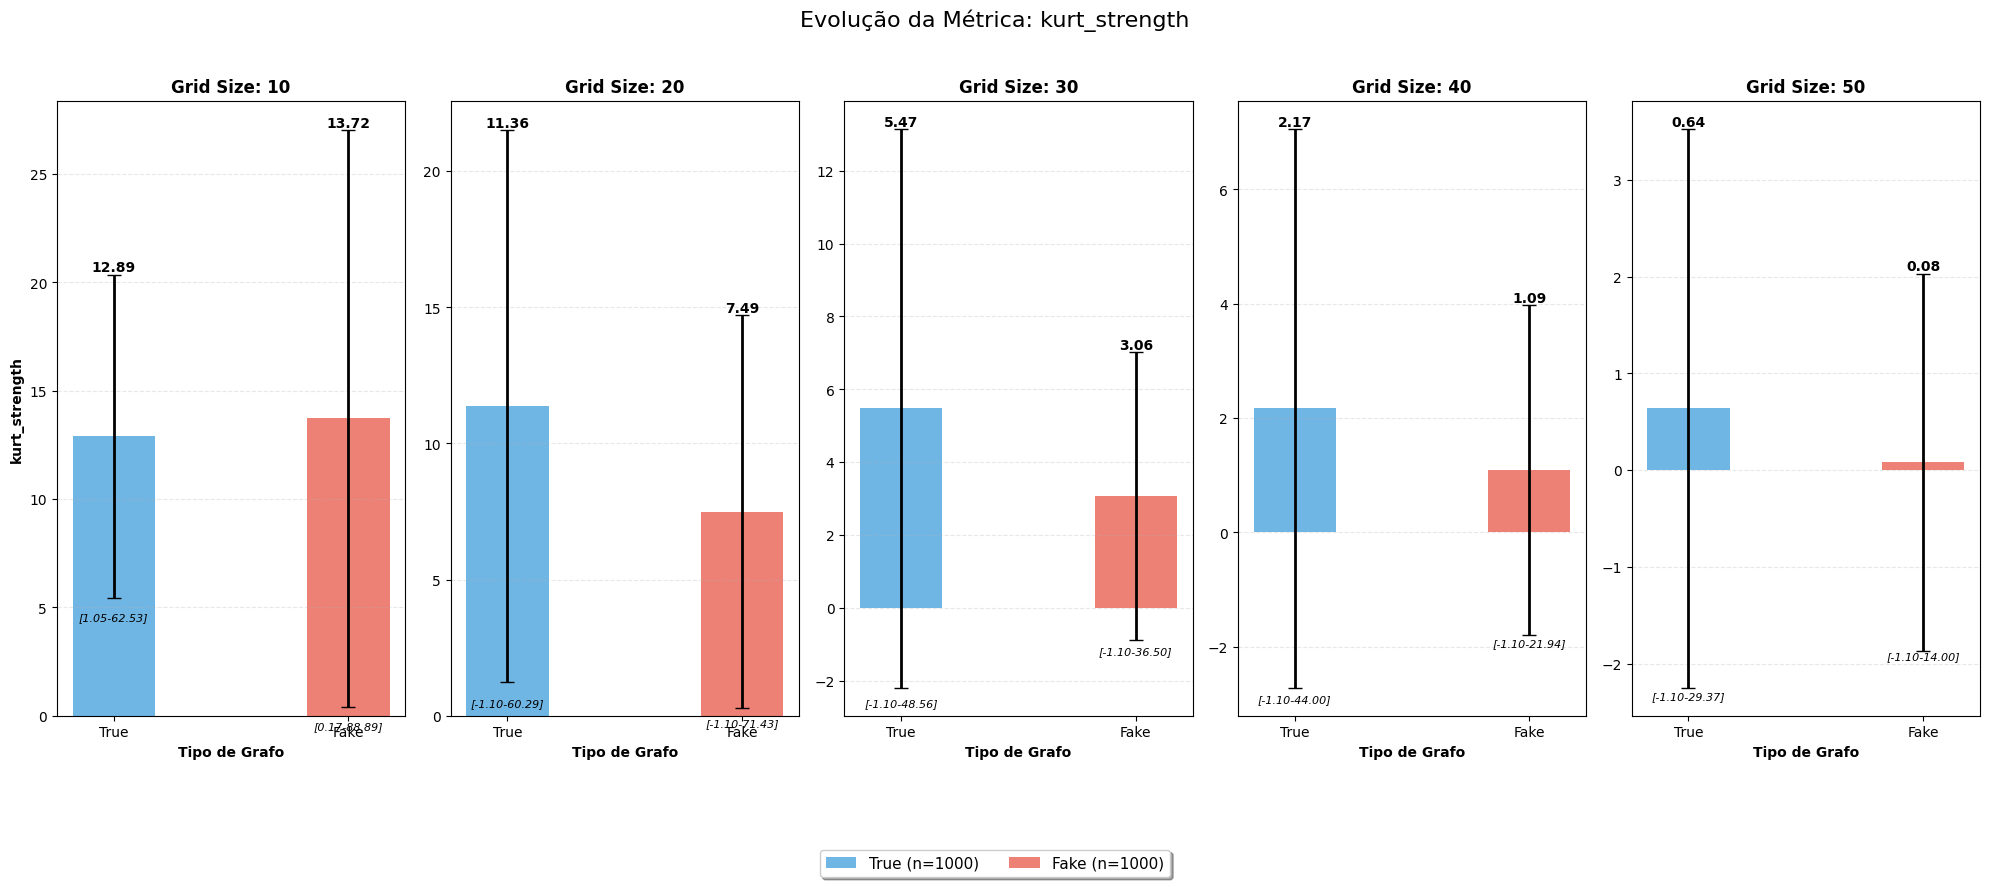

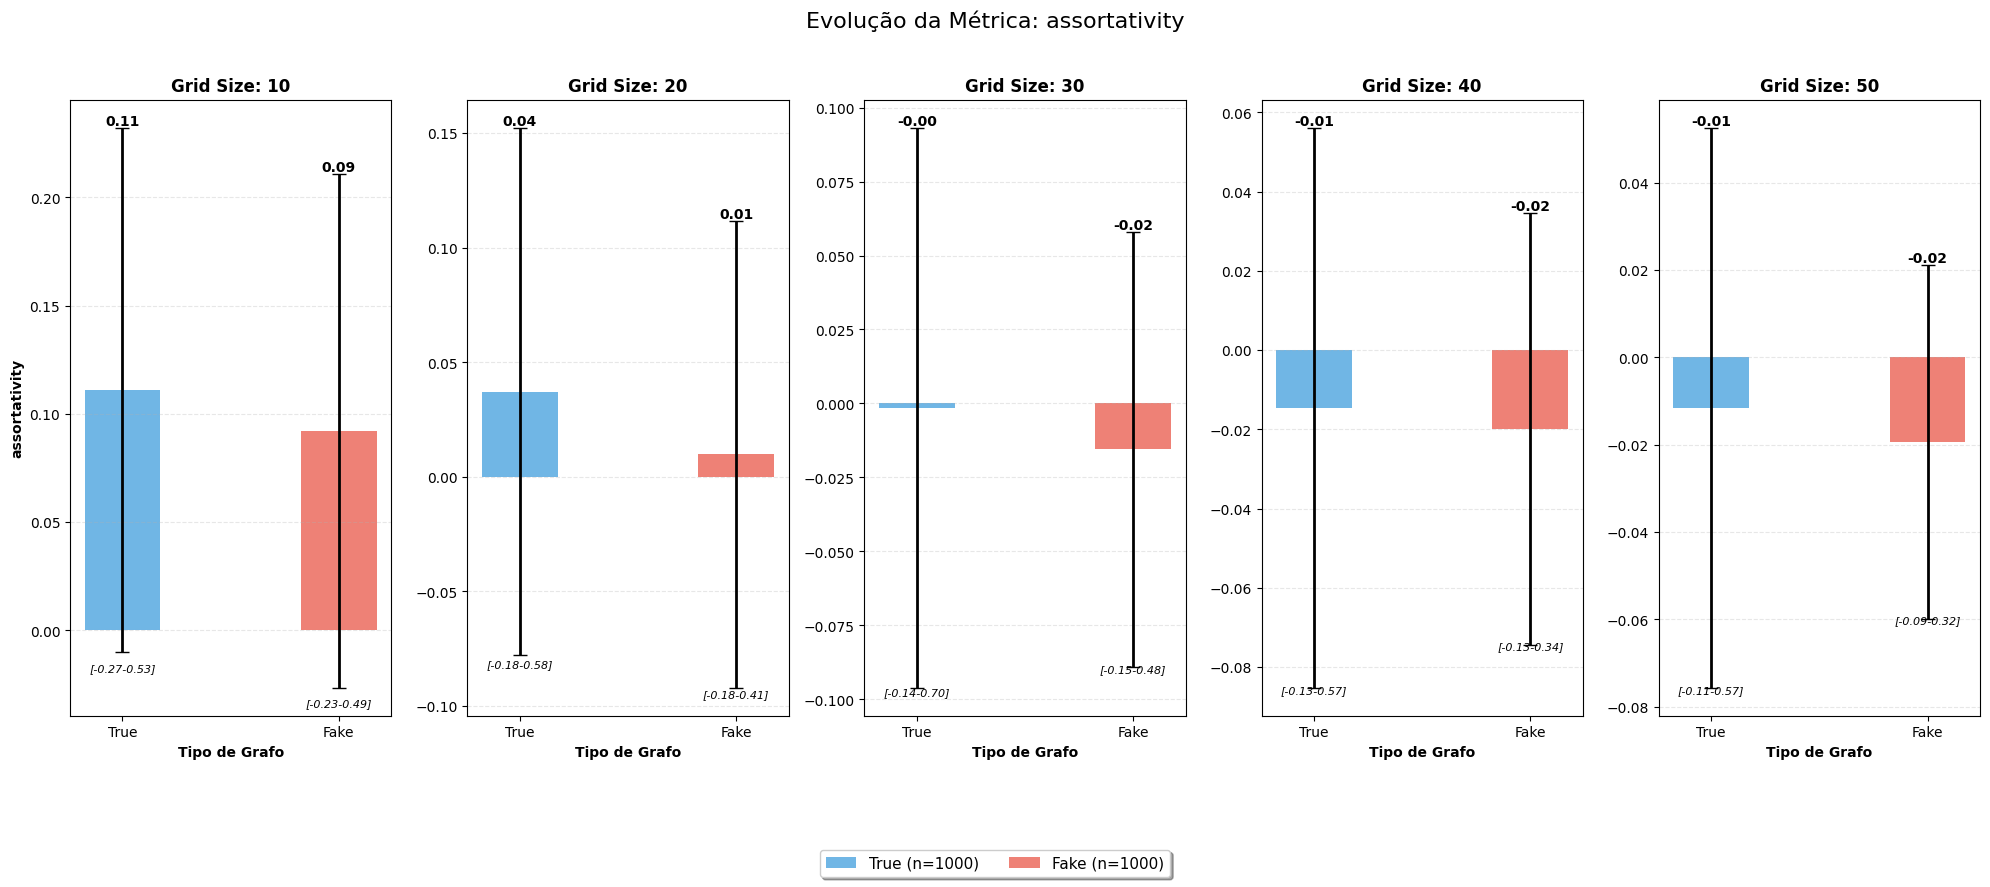

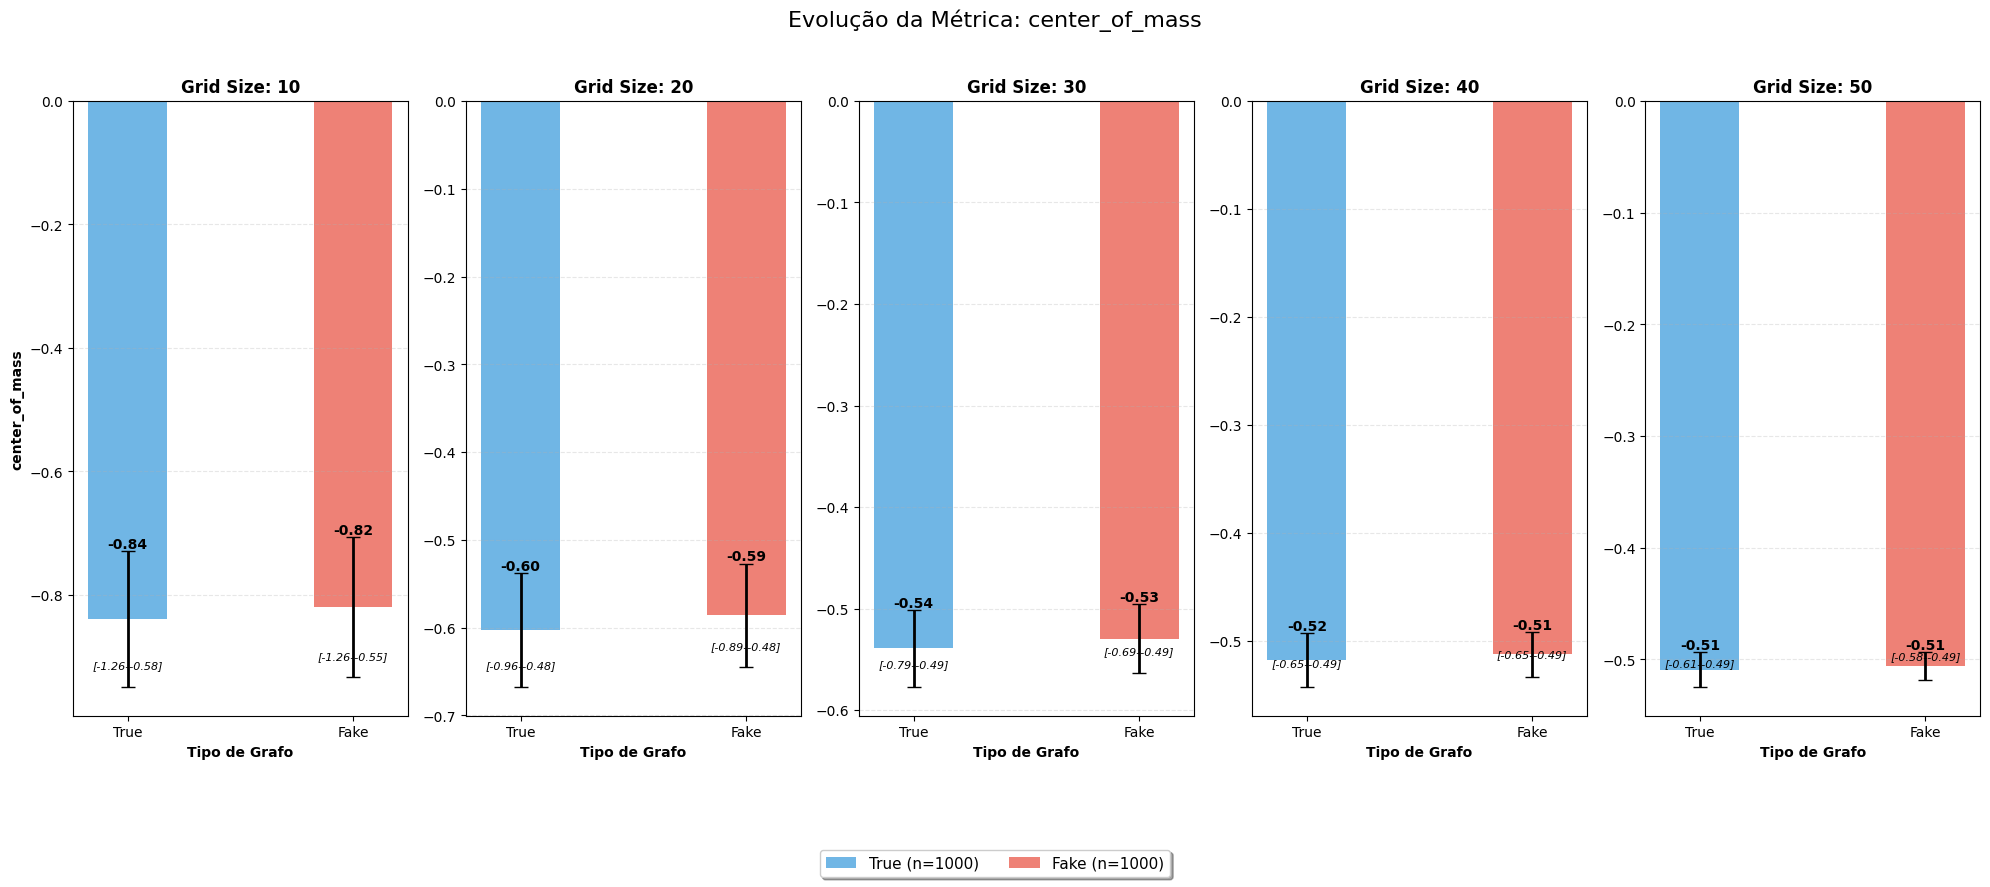


Foram gerados 16 gráficos (um para cada métrica).
Cada barra mostra: valor médio ± desvio padrão
Entre colchetes: [mínimo-máximo]


In [13]:
metrics_df = pd.read_csv(metrics_path)

# Primeiro, vamos identificar quais colunas são métricas (excluir colunas de identificação)
metric_columns = [col for col in metrics_df.columns 
                  if col not in ['grid_size', 'sample', 'graph_label', 'model_name', 'label', 'graph_label', 'center_of_strength']] # The center_of_strength is completely nan

print(f"Total de métricas encontradas: {len(metric_columns)}")
print(f"Métricas: {metric_columns}\n")

plot_metric_evolution_with_stats(metrics_df, metric_columns, GRID_SIZES)

In [16]:
def plot_cumulative_mean_by_metric(df, metric_columns, grid_sizes):
    """
    Plota a média acumulada dos experimentos para cada métrica.
    Para cada métrica, cria um gráfico com 2 subplots (um para true, outro para fake).
    Cada subplot mostra curvas para cada grid_size.
    Mostra a evolução da média acumulada conforme os experimentos progridem.
    """
    
    # Cores para cada grid_size
    colors = plt.cm.Set1(np.linspace(0, 1, len(grid_sizes)))
    
    for metric in metric_columns:
        # Criar figura com 2 subplots (true e fake)
        fig, axes = plt.subplots(
            1, 
            2, 
            figsize=(16, 6),
            sharey=True
        )
        
        fig.suptitle(f'Média Acumulada - Métrica: {metric}', fontsize=16, y=0.98)
        
        # Iterar sobre cada label (true, fake)
        labels = ['true', 'fake']
        for col, label in enumerate(labels):
            ax = axes[col]
            
            # Iterar sobre cada grid_size
            for grid_idx, grid_size in enumerate(grid_sizes):
                # Filtrar dados para grid_size e label específicos
                df_filtered = df[(df['grid_size'] == grid_size) & (df['graph_label'] == label)].copy()
                df_filtered = df_filtered.sort_values('sample')
                
                if len(df_filtered) > 0:
                    # Calcular a média acumulada
                    df_filtered['cumulative_mean'] = df_filtered[metric].expanding().mean()
                    
                    # Plotar linha de média acumulada
                    ax.plot(
                        df_filtered['sample'],
                        df_filtered['cumulative_mean'],
                        linewidth=2.5,
                        color=colors[grid_idx],
                        marker='o',
                        markersize=2,
                        alpha=0.8,
                        label=f'Grid Size: {grid_size}'
                    )
                    
                    # Preencher área sob a curva com transparência
                    # ax.fill_between(
                    #     df_filtered['sample'],
                    #     df_filtered['cumulative_mean'],
                    #     alpha=0.1,
                    #     color=colors[grid_idx]
                    # )
            
            # Adicionar grid
            ax.grid(True, linestyle='--', alpha=0.3)
            
            # Títulos e labels
            ax.set_title(f'{label.capitalize()}', fontsize=13, fontweight='bold')
            ax.set_xlabel('Sample #', fontweight='bold', fontsize=11)
            
            # Label Y apenas no primeiro subplot
            if col == 0:
                ax.set_ylabel(metric, fontweight='bold', fontsize=11)
            
            # Legenda
            ax.legend(loc='lower right', fontsize=10, framealpha=0.95)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\nForam gerados {len(metric_columns)} gráficos de média acumulada.")
    print("Cada gráfico mostra: 2 subplots (true/fake) com curvas para cada grid_size")
    print("A curva mostra a evolução da média conforme os experimentos progridem.")

Total de métricas encontradas: 16
Métricas: ['num_nodes', 'num_edges', 'mean_distance', 'diameter', 'density', 'beetweenness_centrality_mean', 'mean_degree', 'var_degree', 'skew_degree', 'kurt_degree', 'mean_strength', 'var_strength', 'skew_strength', 'kurt_strength', 'assortativity', 'center_of_mass']



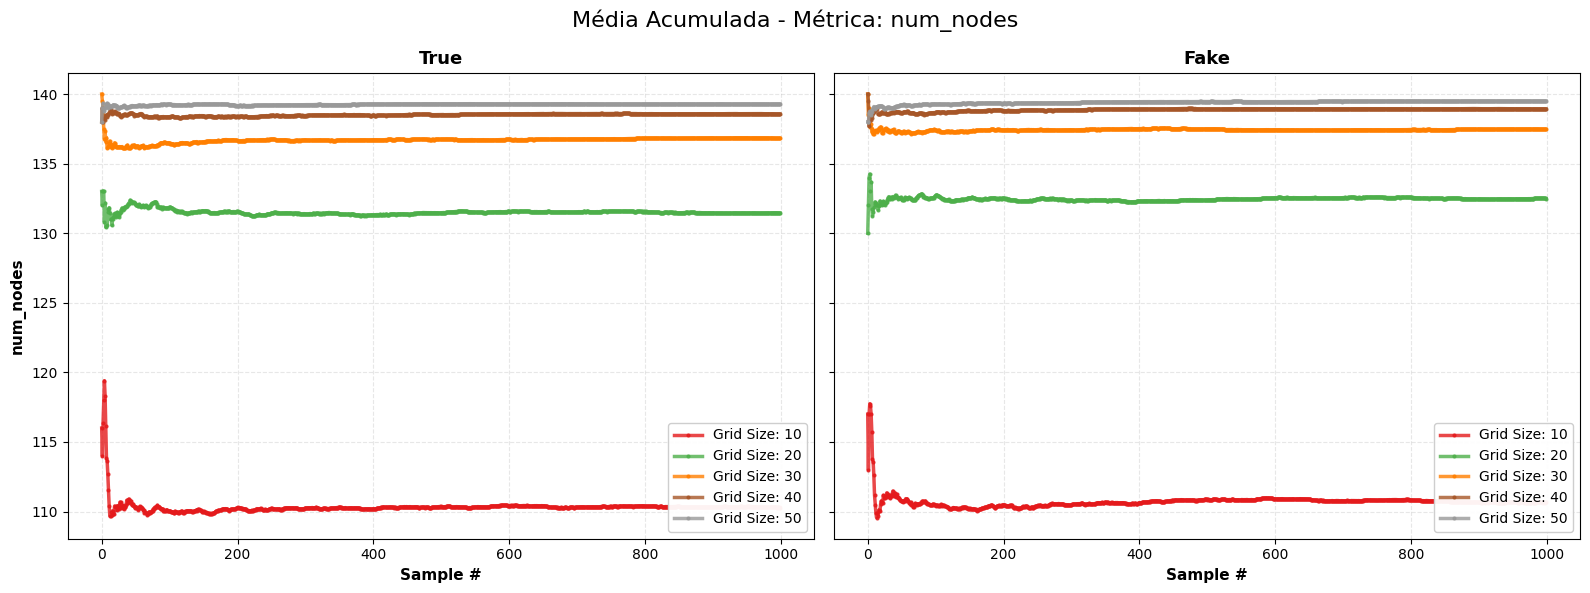

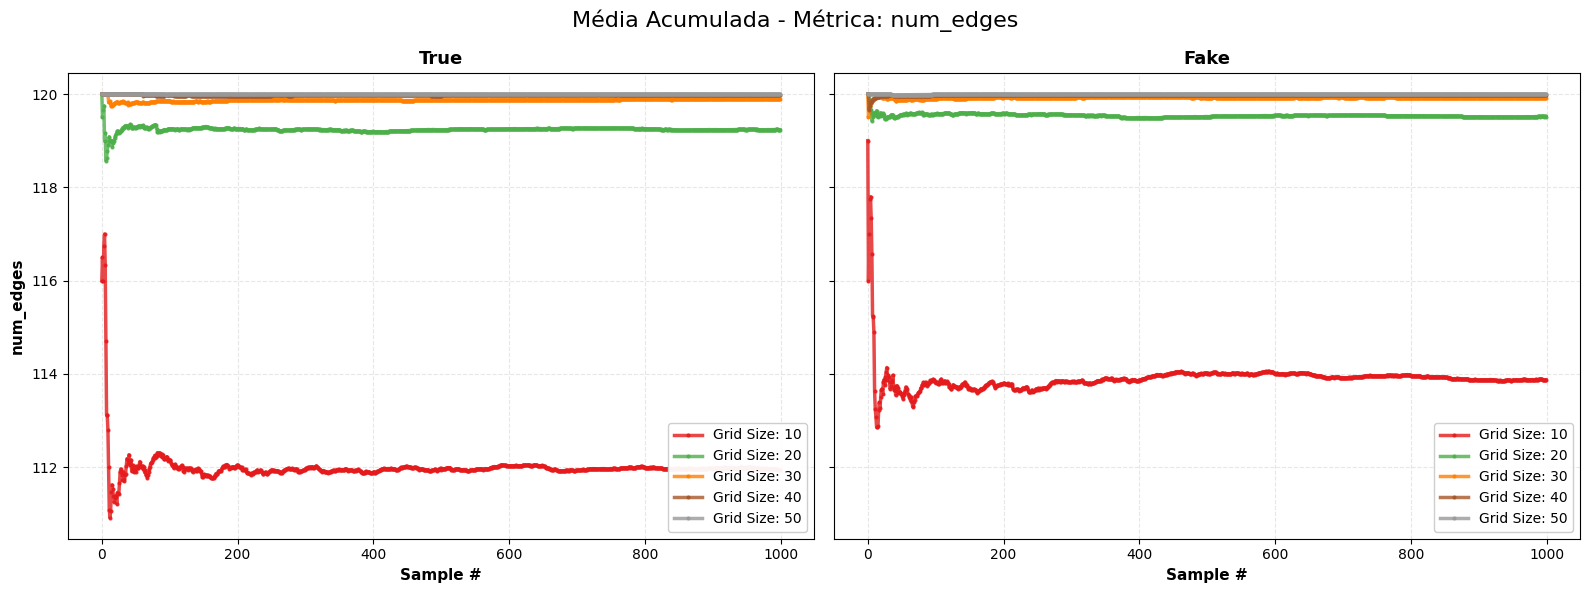

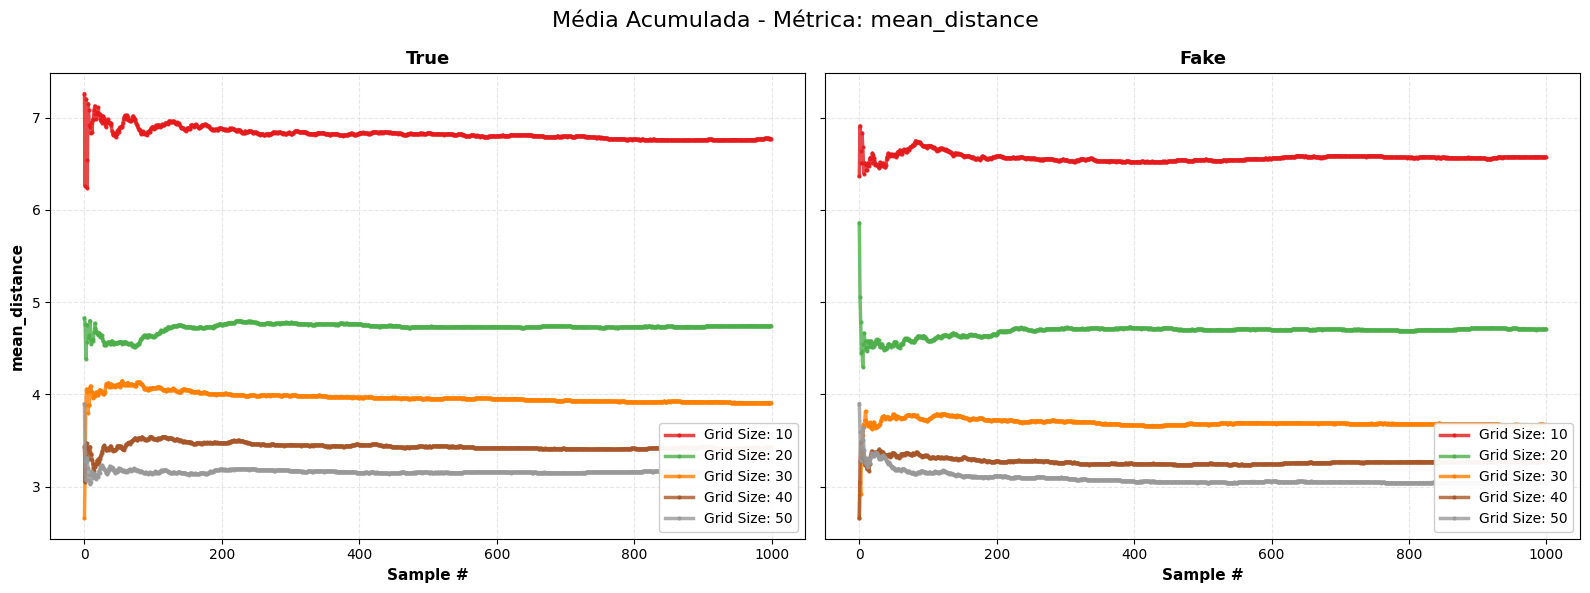

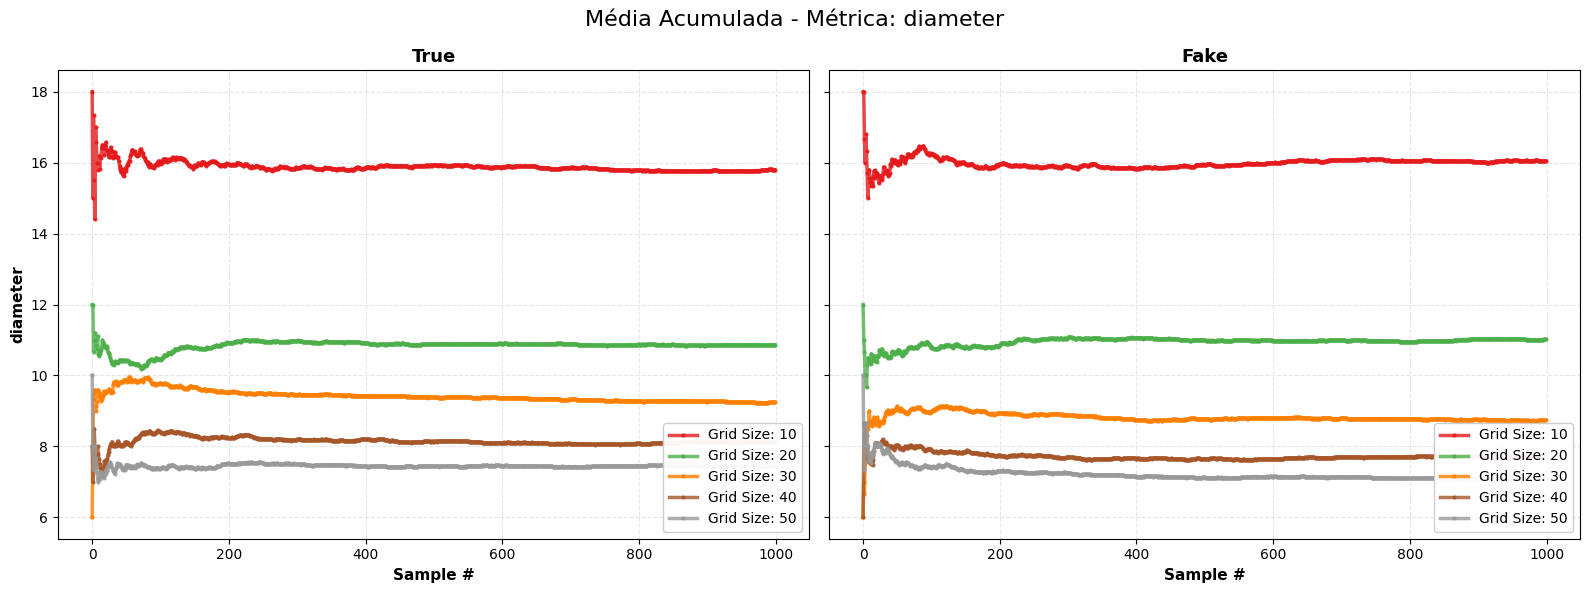

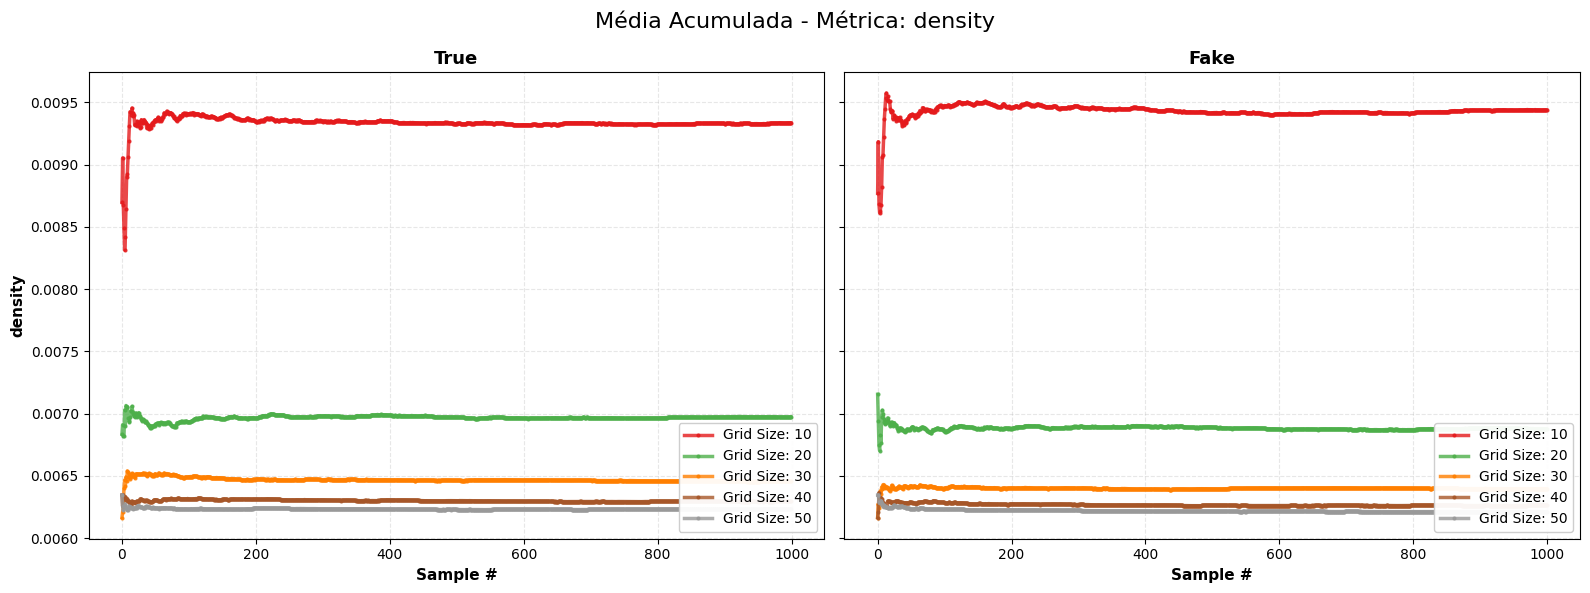

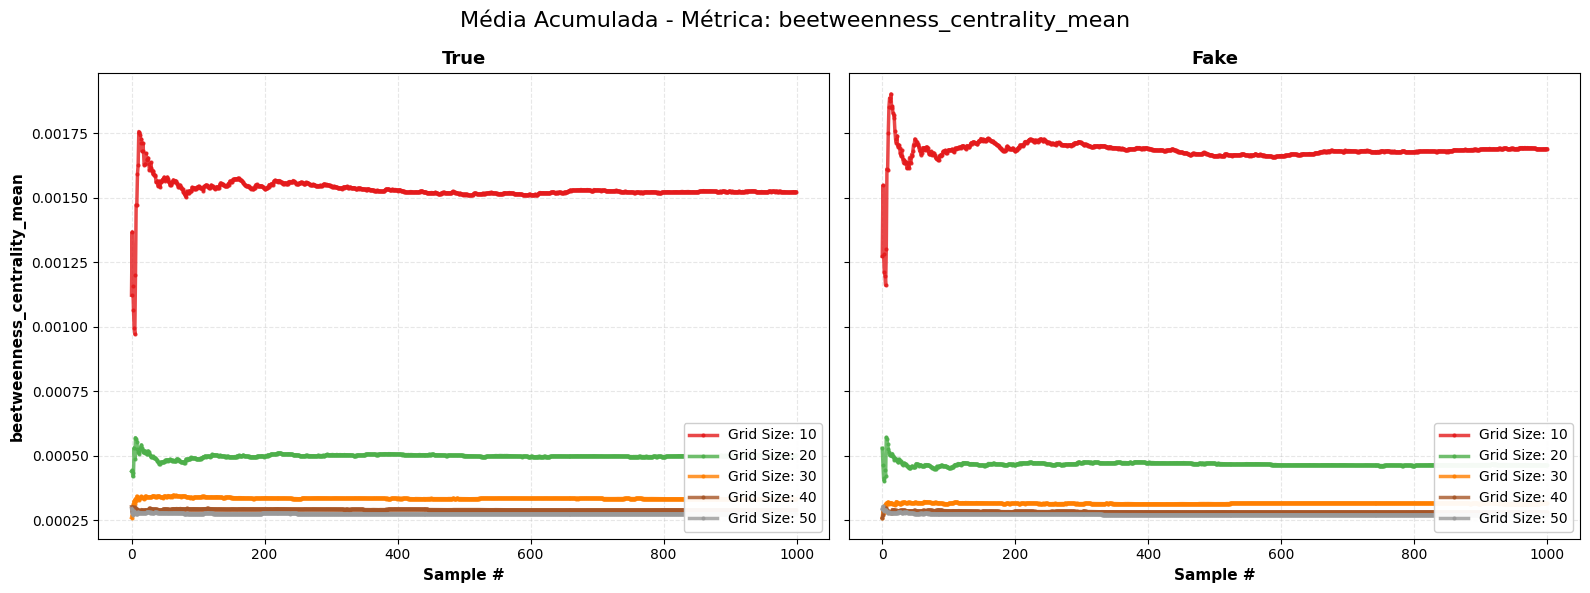

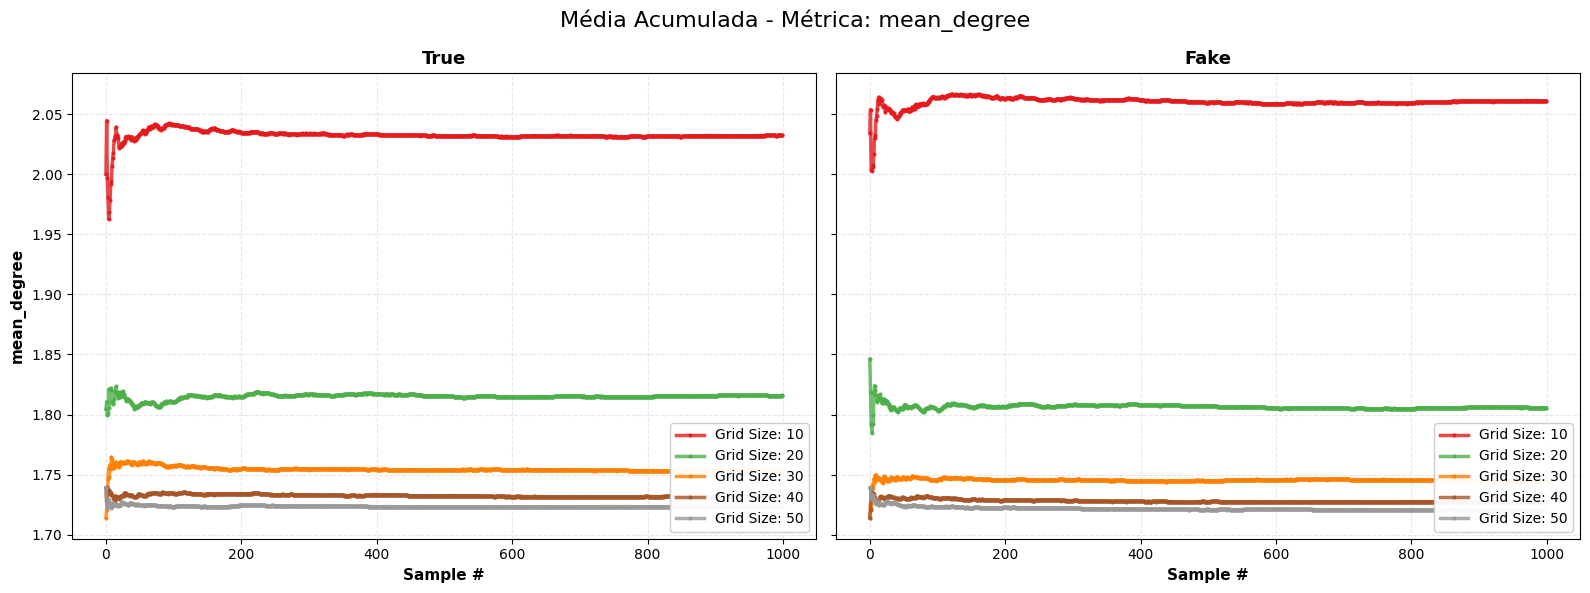

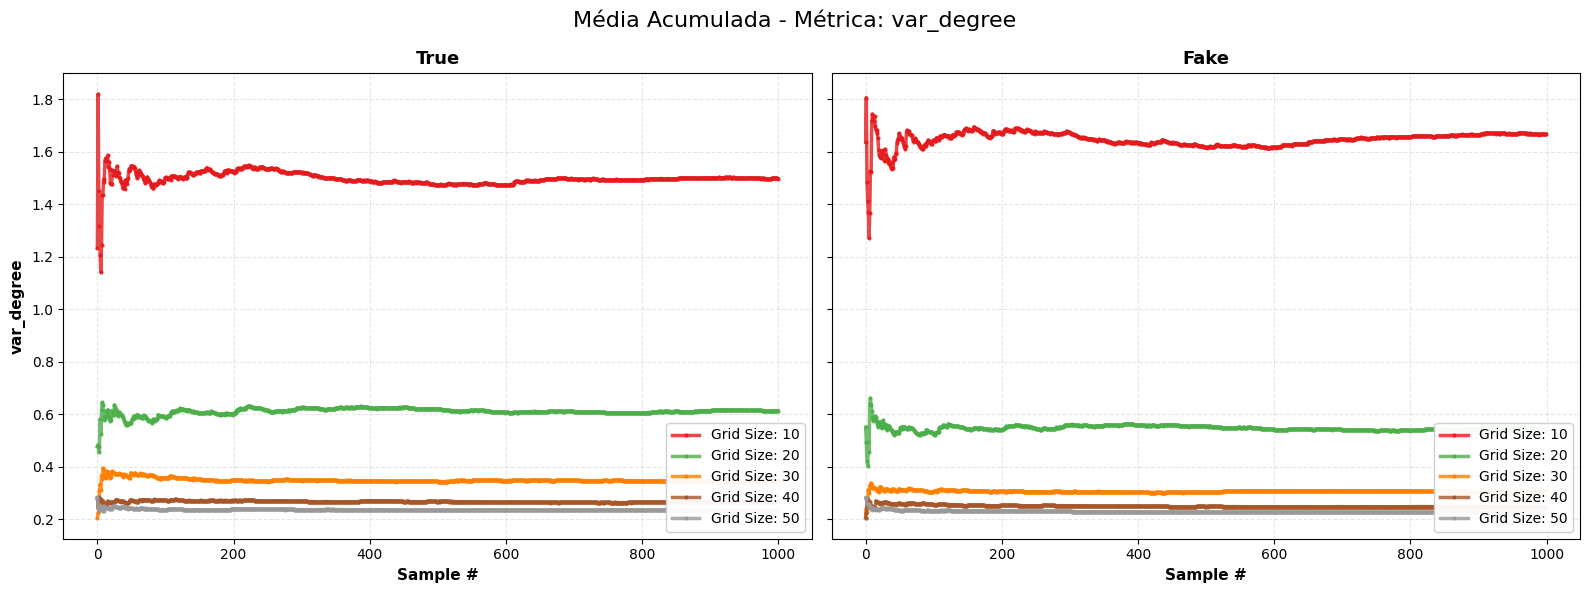

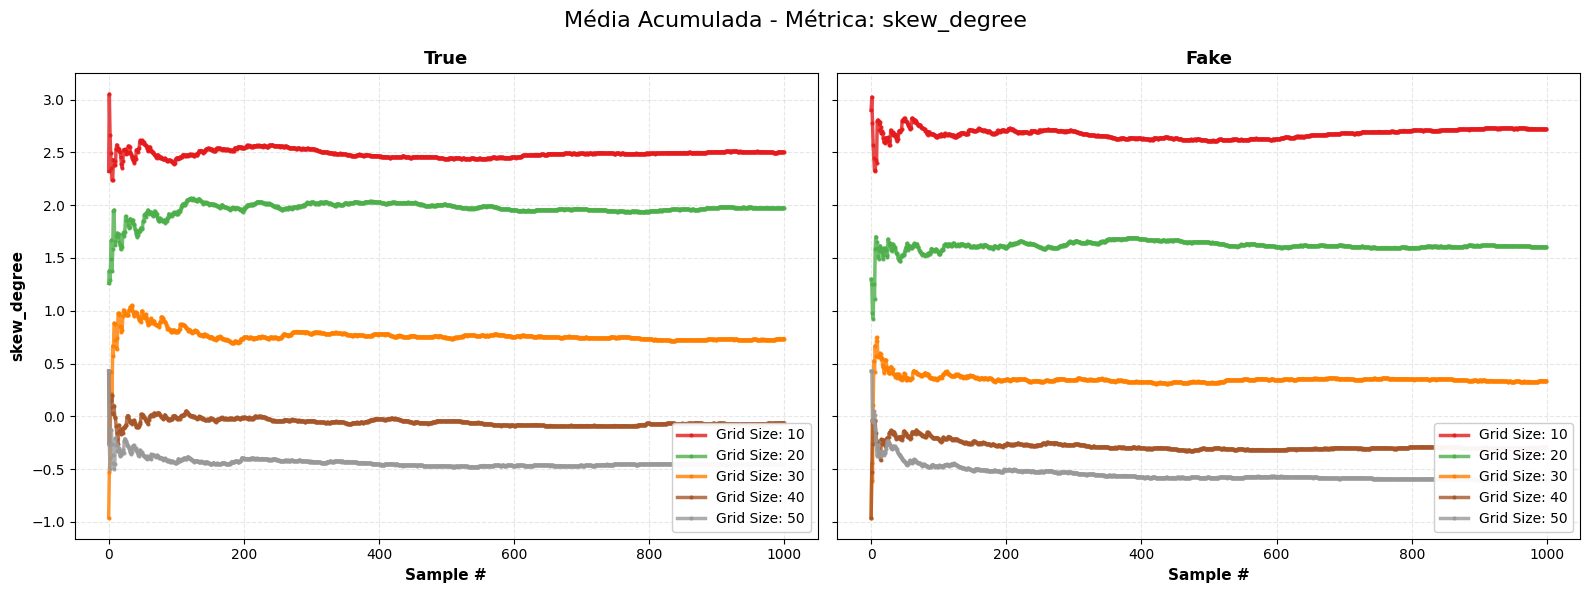

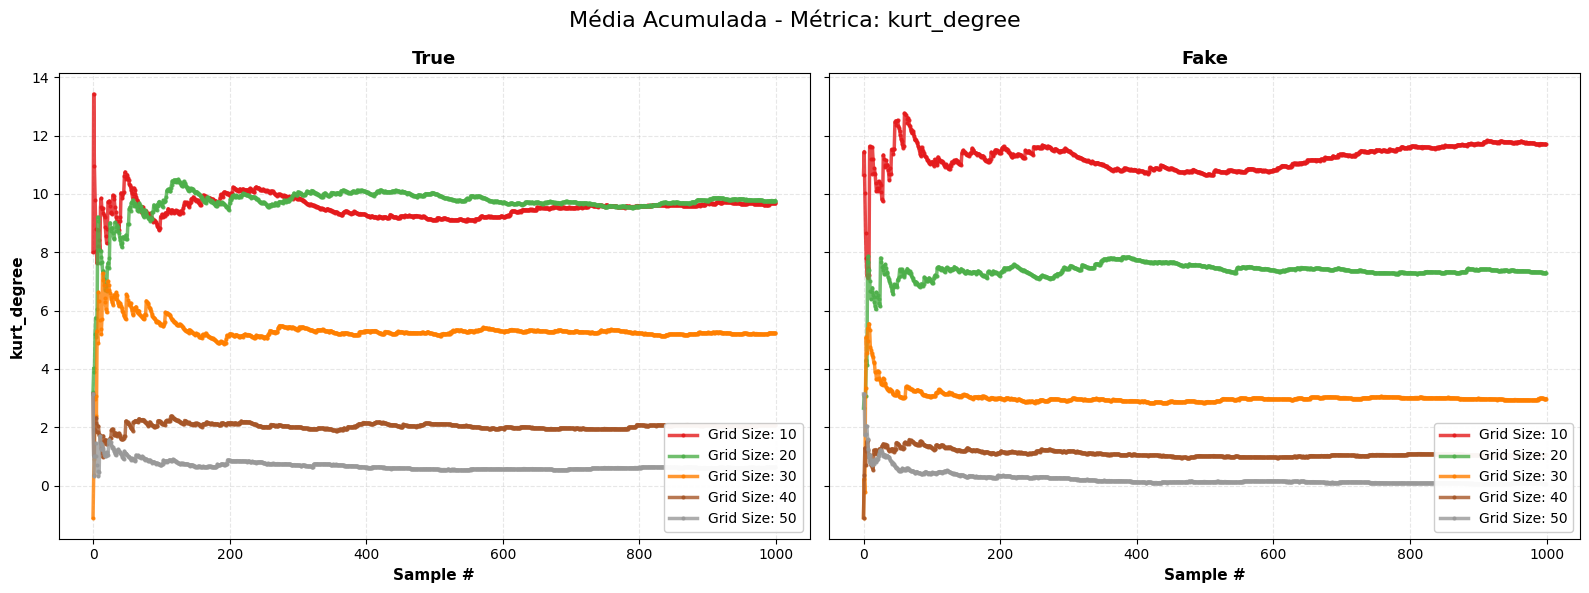

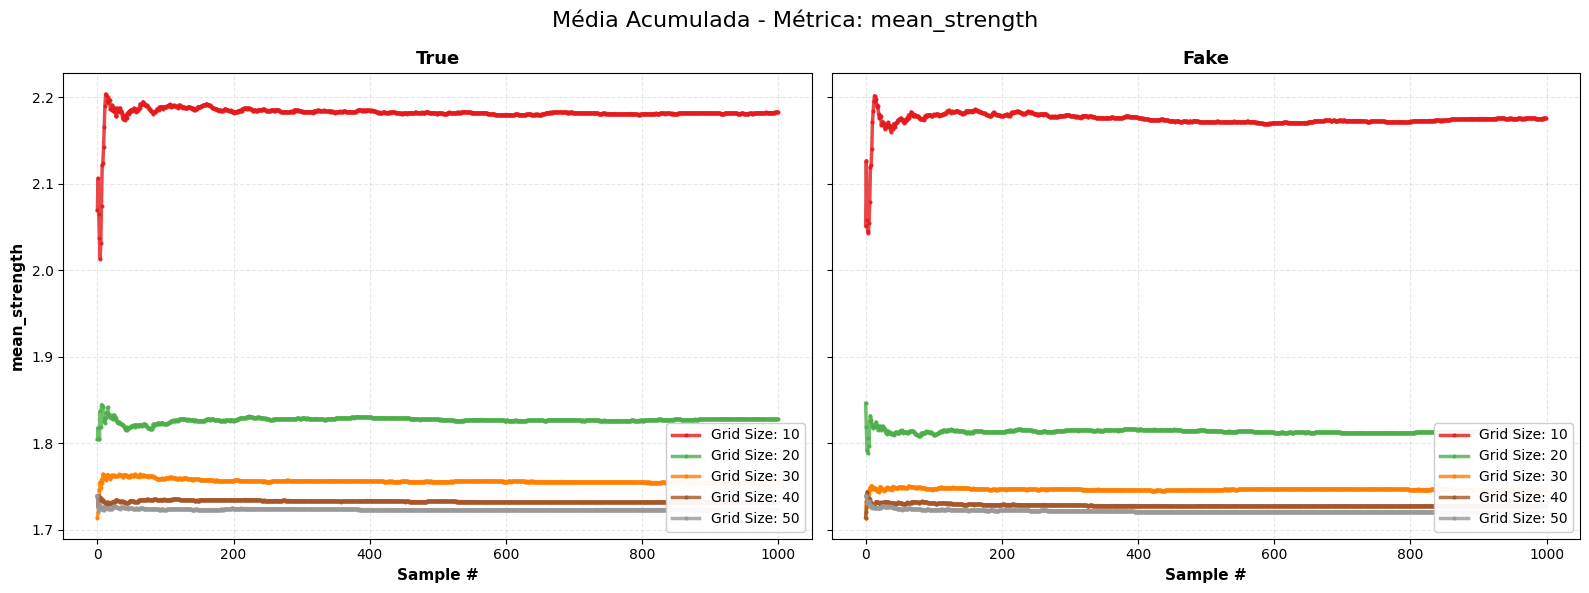

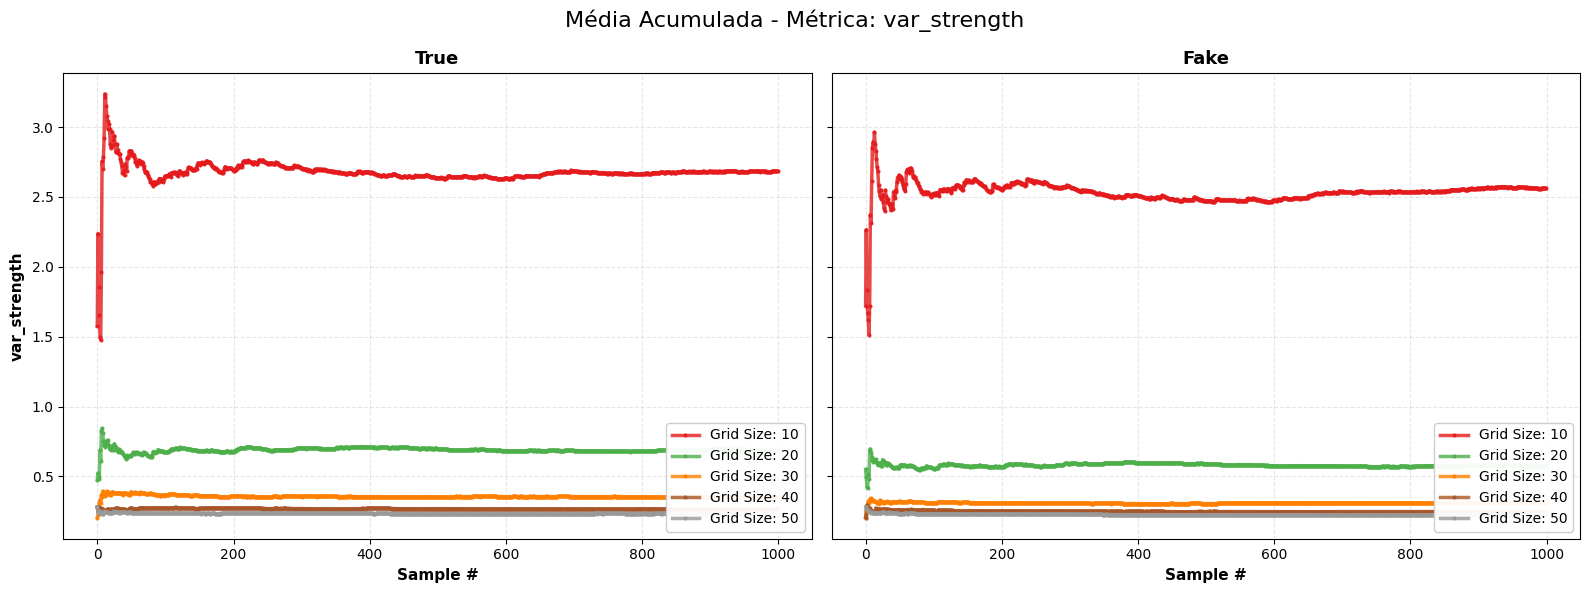

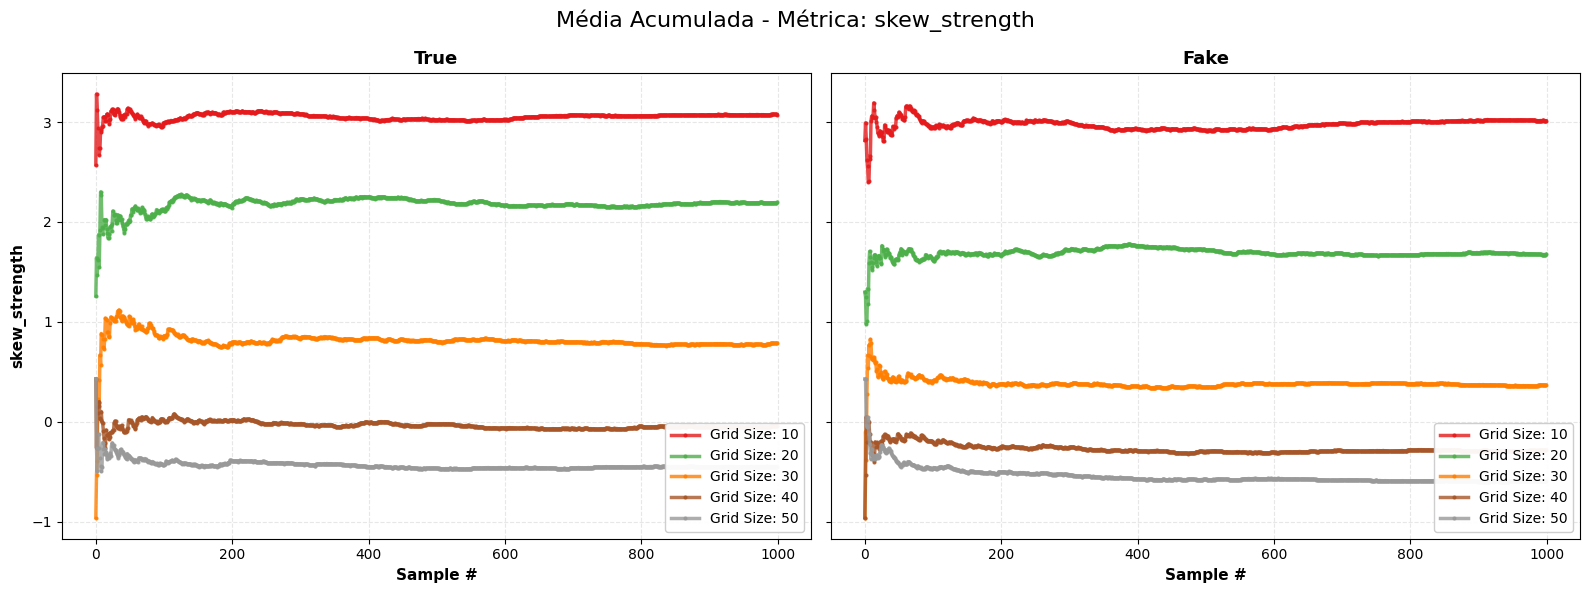

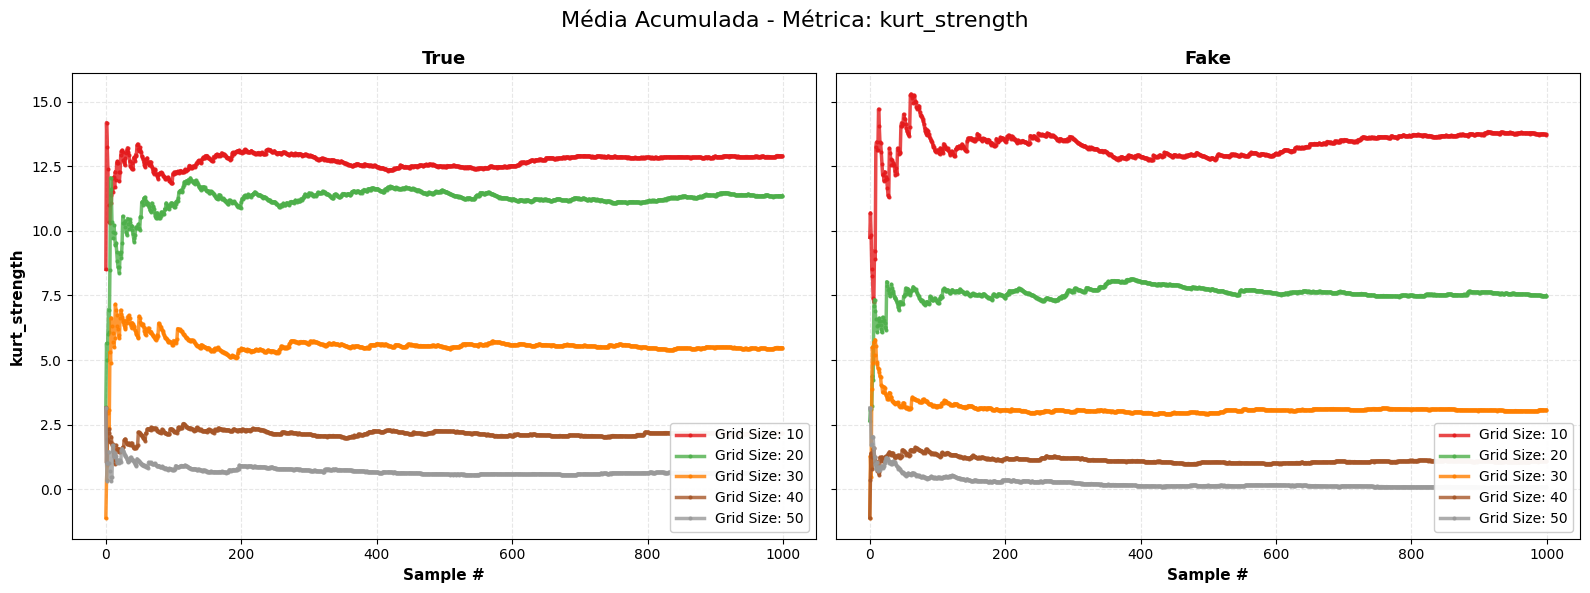

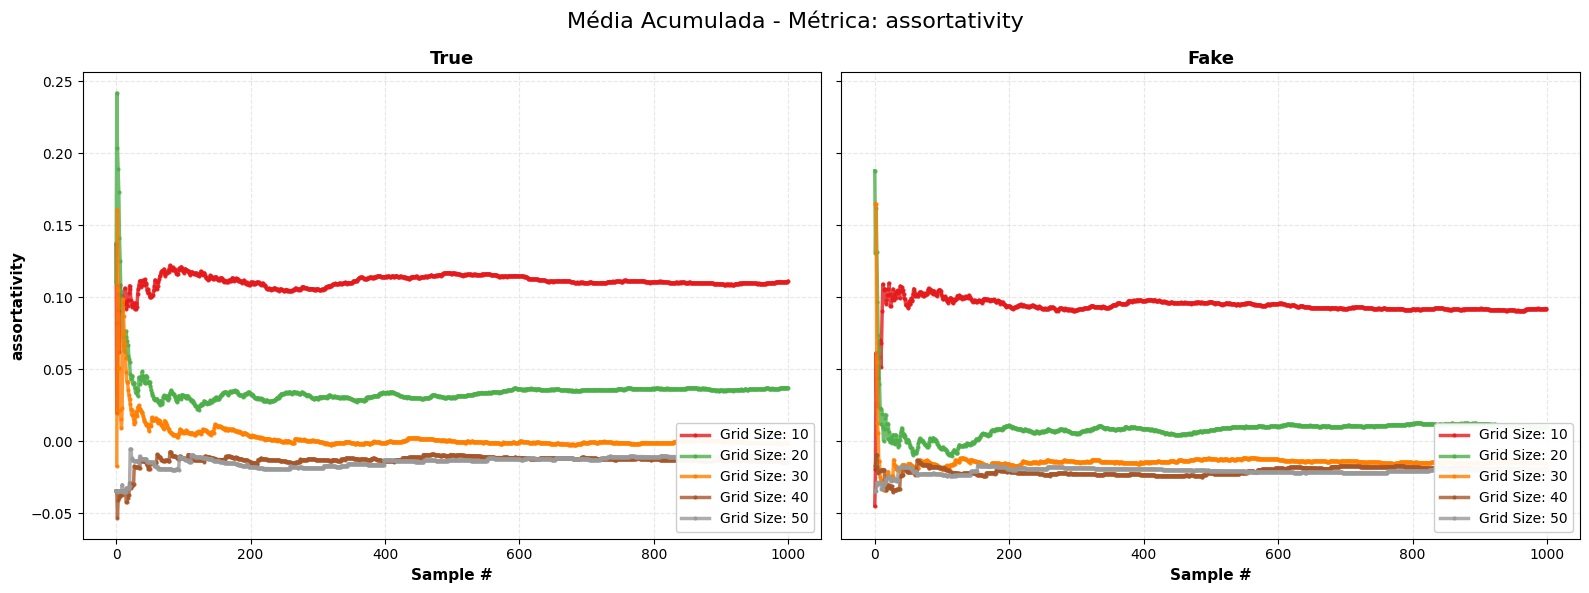

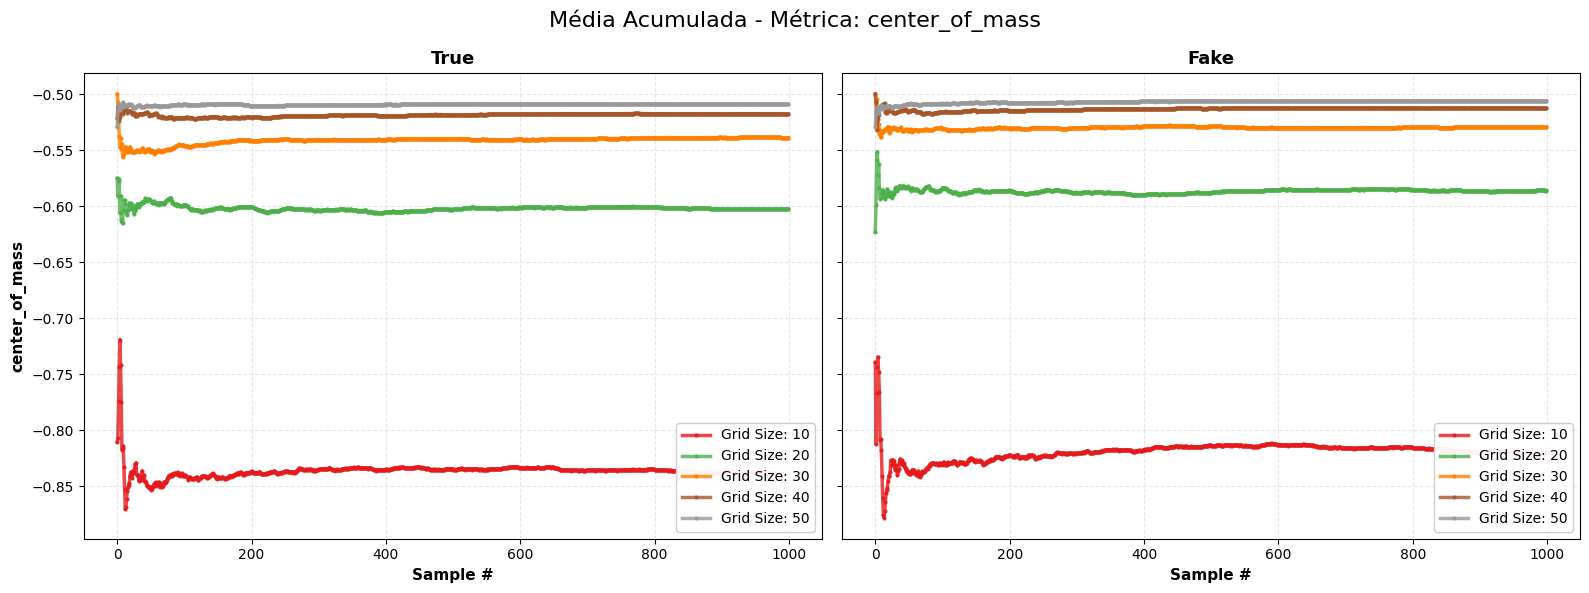


Foram gerados 16 gráficos de média acumulada.
Cada gráfico mostra: 2 subplots (true/fake) com curvas para cada grid_size
A curva mostra a evolução da média conforme os experimentos progridem.


In [17]:
metrics_df = pd.read_csv(metrics_path)

# Primeiro, vamos identificar quais colunas são métricas (excluir colunas de identificação)
metric_columns = [col for col in metrics_df.columns 
                  if col not in ['grid_size', 'sample', 'graph_label', 'model_name', 'label', 'graph_label', 'center_of_strength']] # The center_of_strength is completely nan

print(f"Total de métricas encontradas: {len(metric_columns)}")
print(f"Métricas: {metric_columns}\n")

plot_cumulative_mean_by_metric(metrics_df, metric_columns, GRID_SIZES)

## Número de nós por camada

### Get Metrics per Layer

In [17]:
def merge_data_from_dicts(d1, d2):
    all_keys = d1.keys() | d2.keys()

    d2_value_type = type(list(d2.values())[0])
    if d2_value_type is list:
        return {k: [*d1.get(k, []), *d2.get(k, [])] for k in all_keys}
    
    return {k: [*d1.get(k, []), d2.get(k, 0)] for k in all_keys}


def get_degree_per_layer(graph):
    degree_per_layer = dict()
    current_graph_degree = graph.degree()
    for node, degree in current_graph_degree:
        layer = get_layer_number(node)
        if layer in degree_per_layer:
            degree_per_layer[layer].append(degree)
        else:
            degree_per_layer[layer] = [degree]
    return degree_per_layer

def get_num_nodes_per_layer(graph):
    nodes_per_layer = dict()
    for node in graph.nodes():
        layer = get_layer_number(node)
        if layer in nodes_per_layer:
            nodes_per_layer[layer] += 1
        else:
            nodes_per_layer[layer] = 1
    return nodes_per_layer

def get_num_edges_per_layer(graph):
    edges_per_layer = dict()
    for source, target in graph.edges():
        edge_name = get_edge_name(source, target)
        if edge_name in edges_per_layer:
            edges_per_layer[edge_name] += 1
        else:
            edges_per_layer[edge_name] = 1
    return edges_per_layer

def get_metric_function(metric_name=None):
    metric_name_dict = {
        "degree_per_layer": get_degree_per_layer,
        "num_nodes_per_layer": get_num_nodes_per_layer,
        "num_edges_per_layer": get_num_edges_per_layer,
    }
    if metric_name is None:
        return metric_name_dict
    return metric_name_dict.get(metric_name)
    

In [19]:
# Limpa o arquivo existente
metrics_per_layers_path = f"{results_path}/metrics_per_layers.json"
# Remove o arquivo se existir, depois cria um novo vazio
if os.path.exists(metrics_per_layers_path):
    os.remove(metrics_per_layers_path)
with open(metrics_per_layers_path, "w") as f:
    pass


final_metrics = dict()

for grid_size in GRID_SIZES:
    final_metrics[grid_size] = dict()
    
    for label_type  in ["true", "fake"]:
        final_metrics[grid_size][label_type] = dict()

        for metric_name, metric_func in get_metric_function().items():
        
            general_metric_per_layer = dict()
            
            # for sample in range(SAMPLE_SIZE):
            for sample in range(10):

                current_graph = nx.read_gexf(f"{processed_graphs_path}/{grid_size}/g_{label_type}_{sample}.gexf")

                # Get degree per layer
                current_metric_per_layer = metric_func(current_graph)
                general_metric_per_layer = merge_data_from_dicts(
                    general_metric_per_layer, current_metric_per_layer
                )

            # Calculate mean and standard error per layer
            metric_means = {}
            metric_stderr = {}
            for layer, metrics in general_metric_per_layer.items():
                
                metric_means[layer] = np.mean(metrics)
                metric_stderr[layer] = np.std(metrics) / np.sqrt(len(metrics))

            # Store metrics for the current group
            final_metrics[grid_size][label_type][metric_name] = {
                k: {
                    "mean": metric_means[k],
                    "stderr": metric_stderr[k],
                }
                for k in metric_means.keys()
            }


with open(
    metrics_per_layers_path,
    "w",
) as f:
    json.dump(final_metrics, f)

### Plot Results per Layer

In [20]:
# Load metrics per layers data
with open(metrics_per_layers_path, "r") as f:
    metrics_per_layers_data = json.load(f)

print("Dados carregados com sucesso!")
print(f"Grid sizes disponíveis: {list(metrics_per_layers_data.keys())}")
print(f"Métricas disponíveis: {list(metrics_per_layers_data['10']['true'].keys())}")


Dados carregados com sucesso!
Grid sizes disponíveis: ['10', '20', '30', '40', '50']
Métricas disponíveis: ['degree_per_layer', 'num_nodes_per_layer', 'num_edges_per_layer']



Grid Size: 10
Plotting num_nodes_per_layer...


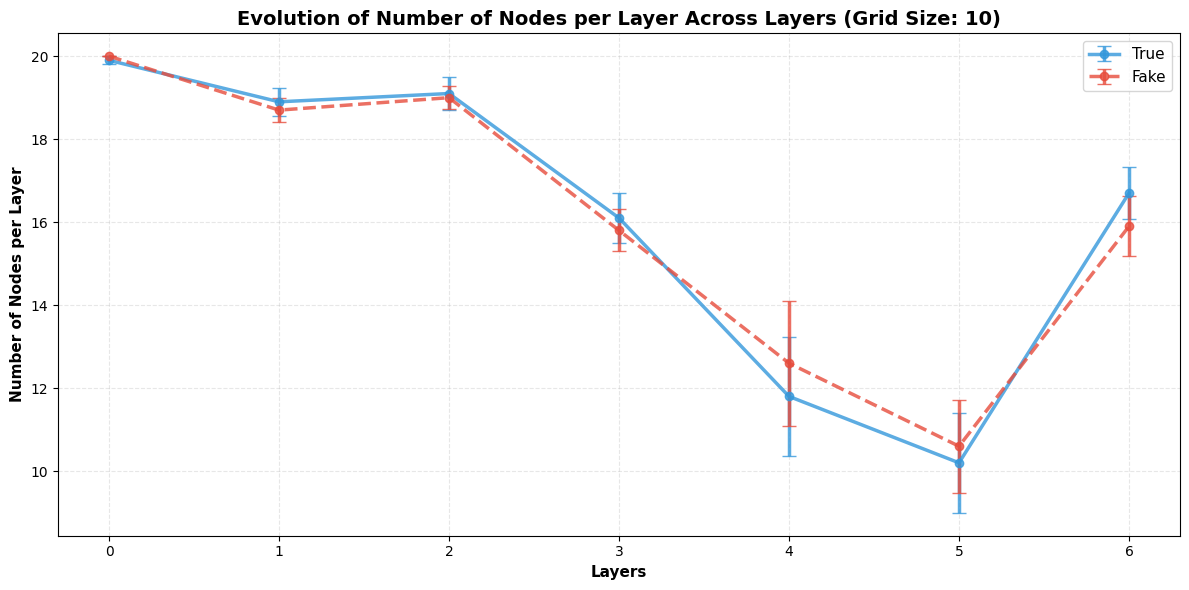


Grid Size: 20
Plotting num_nodes_per_layer...


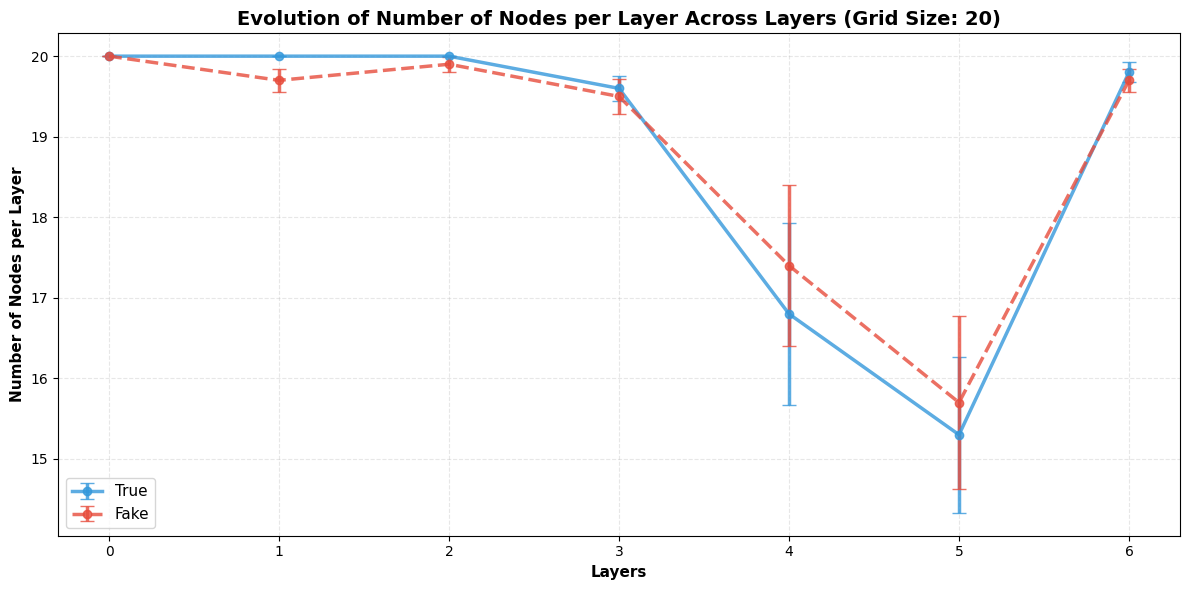


Grid Size: 30
Plotting num_nodes_per_layer...


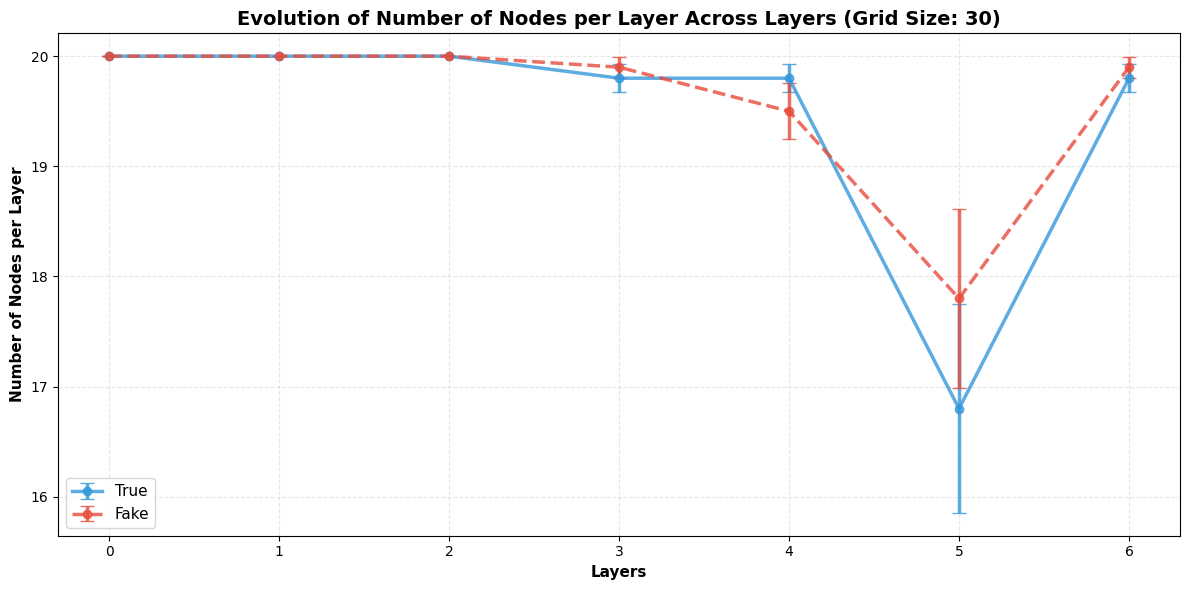


Grid Size: 40
Plotting num_nodes_per_layer...


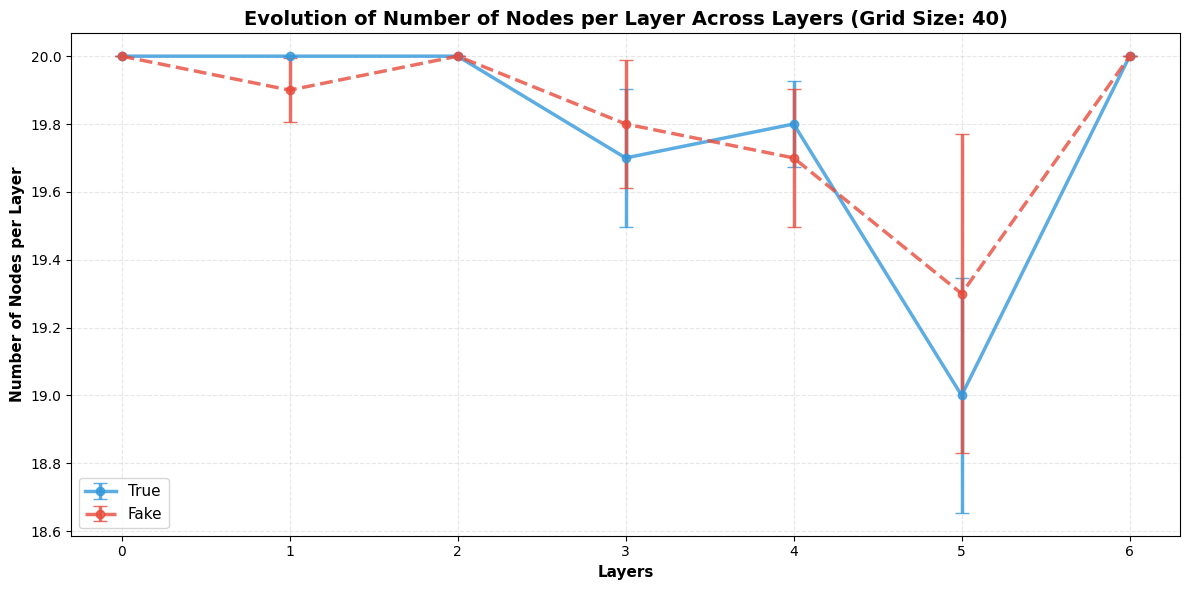


Grid Size: 50
Plotting num_nodes_per_layer...


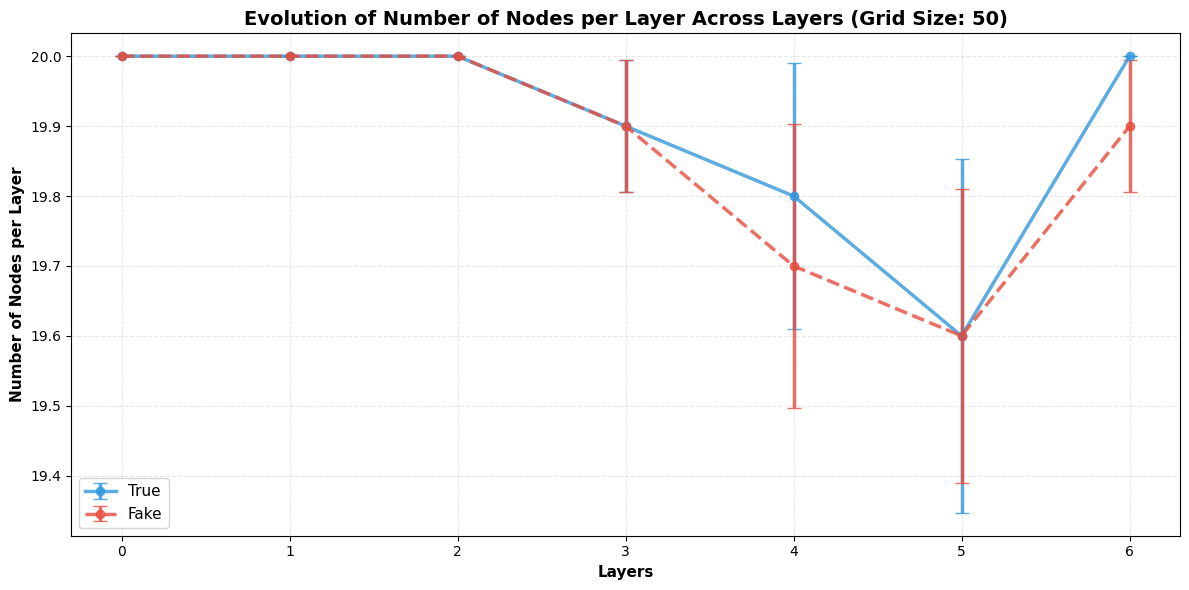

In [24]:
def plot_layer_evolution(data, grid_size, metric_name, ylabel=None):
    """
    Plot the evolution of a metric across layers for a specific grid size.
    Shows two lines: one for 'true' and one for 'fake' labels.
    
    Args:
        data: Data loaded from metrics_per_layers.json
        grid_size: Grid size to plot
        metric_name: Name of the metric to plot ('degree_per_layer', 'num_nodes_per_layer', 'num_edges_per_layer')
        ylabel: Label for y-axis (if None, uses metric_name)
    """
    plt.figure(figsize=(12, 6))
    
    # Define colors for each label type
    colors = {
        "true": "#3498db",
        "fake": "#e74c3c"
    }
    
    # Define line styles
    linestyles = {
        "true": "-",
        "fake": "--"
    }
    
    # Iterate over label types (true and fake)
    for label_type in ["true", "fake"]:
        metric_data = data[grid_size][label_type][metric_name]
        
        # Extract layers, means, and standard errors
        # For num_edges_per_layer, the keys are like "0>>1", "1>>2", etc.
        # For degree_per_layer and num_nodes_per_layer, keys are layer numbers
        
        # Sort layers appropriately
        if metric_name == "num_edges_per_layer":
            # For edges, sort by first layer number
            sorted_layers = sorted(metric_data.keys(), key=lambda x: int(x.split(">>")[0]))
        else:
            # For nodes and degree, sort numerically
            sorted_layers = sorted(metric_data.keys(), key=lambda x: int(x))
        
        means = [metric_data[layer]["mean"] for layer in sorted_layers]
        stderrs = [metric_data[layer]["stderr"] for layer in sorted_layers]
        
        # Plot with error bars
        plt.errorbar(
            sorted_layers,
            means,
            yerr=stderrs,
            label=f"{label_type.capitalize()}",
            capsize=5,
            color=colors[label_type],
            linestyle=linestyles[label_type],
            linewidth=2.5,
            marker='o',
            markersize=6,
            alpha=0.8
        )
    
    # Set labels and title
    if ylabel is None:
        ylabel = metric_name
    
    plt.title(f"Evolution of {ylabel} Across Layers (Grid Size: {grid_size})", fontsize=14, fontweight='bold')
    plt.xlabel("Layers", fontweight='bold', fontsize=11)
    plt.ylabel(ylabel, fontweight='bold', fontsize=11)
    plt.legend(fontsize=11, loc='best')
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()


# Define metric display names
metric_labels = {
    # "degree_per_layer": "Mean Degree per Layer",
    "num_nodes_per_layer": "Number of Nodes per Layer",
    # "num_edges_per_layer": "Number of Edges per Layer"
}

# Plot for each grid size and each metric
for grid_size in GRID_SIZES:
    print(f"\n{'='*60}")
    print(f"Grid Size: {grid_size}")
    print(f"{'='*60}")
    
    
    # for metric_name in get_metric_function().keys():
    for metric_name in ["num_nodes_per_layer"]:
        print(f"Plotting {metric_name}...")
        ylabel = metric_labels.get(metric_name, metric_name)
        plot_layer_evolution(metrics_per_layers_data, str(grid_size), metric_name, ylabel)
